<a href="https://colab.research.google.com/github/gitsteveo/notebooks/blob/master/Pairs_selection_process.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pairs selection process
The aim of the notebook is to identify the pairs with the highest expected profit for the pairs strategy from a universe of stocks. 

To do this, illiquid equities are first filtered out, then pair combinations are formed in which the members come from the same sector/industry, and finally a combo factor is formed from the historical performance (linear strategy return = lsr) and relative distance of both stocks (euclidian distance factor = edf), on the basis of which the pairs are sorted.

We're doing this over a sample period of roughly 2 years to identify the pairs we want to trade for the next year.



# Preparation

## Set working dir, dependencies

In [ ]:
setwd("~/Documents/Resilio/jupyter/pairs_pipeline")

In [ ]:
# Read environment variables
readRenviron(".env")
eodhd_key <<- Sys.getenv("EODHD_KEY")

In [ ]:
# snippet: set plot options v0.1
options(repr.plot.width = 14, repr.plot.height=7)
theme_update(text = element_text(size = 16))

## Loading dependencies

In [ ]:
# snippet: rw load rwrtools v0.1
if(!require("pacman")) install.packages("pacman")
#pacman::p_load_current_gh("RWLab/rwRtools", dependencies = TRUE)
pacman::p_load(tidyverse, dplyr, lubridate, zoo, corrr,quantmod,anytime,tidyquant,feather,PerformanceAnalytics,timetk, riingo, RcppRoll,TTR,SciViews,glasso, glue)
p_load_current_gh("mdelhey/mdutils")

# Custom packages
devtools::install_github("simonkrebs1283/scrapr")
devtools::install_github("simonkrebs1283/eodhistoricaldata")

Using github PAT from envvar GITHUB_PAT

Skipping install of 'scrapr' from a github remote, the SHA1 (785999ac) has not changed since last install.
  Use `force = TRUE` to force installation

Using github PAT from envvar GITHUB_PAT

Skipping install of 'eodhistoricaldata' from a github remote, the SHA1 (632b9454) has not changed since last install.
  Use `force = TRUE` to force installation



## Source pipeline functions
The main source code for this notebook lays in two R scripts, we're now loading them.


In [ ]:
# Source pairs pipeline functions
source("pipeline_functions.R") # calculation of spreads, features ..
source("plot_functions.R") # plotting functions

## Define filter parameters
We're now setting our global parameters for the filtering process:

In [ ]:
date_from <- "2020-05-01"
date_to <- today() # approx 2 years of data
lookback <- 20

min_avg_close <- 5
min_market_cap <- 1e+09
min_avg_volume <- 300000

# Loading raw data
## What we need:

1. A universe of stock tickers
2. Historical market cap data
3. Sector/industry classifications (don't need to have a history, rather static data set)
4. Historical price data (1d)

## Stock tickers universe (1)

### Reading from Alpaca
We define our universe through the tradable assets of Alpaca. The API allows us to download all tickers available. Then we filter by whether the assets are active, tradable and shortable (!).

In [ ]:
# Reading all assets available on Alpaca
alpaca_assets <- AlpacaforR::assets()

Warning message:
“All formats failed to parse. No formats found.”


In [ ]:
alpaca_assets %>% head(1)

id,class,exchange,symbol,name,status,tradable,marginable,shortable,easy_to_borrow,fractionable,min_order_size,min_trade_increment,price_increment
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<chr>,<chr>,<chr>
961a89ca-47b3-4bde-8557-22ef043e3319,us_equity,OTC,PINVF,Pinnacle Invt Mgmt Group Ltd Common Shares (Australia),inactive,FALSE,FALSE,FALSE,FALSE,FALSE,NA,NA,NA


In [ ]:
tickers <- alpaca_assets %>% 
  filter(class=="us_equity" & status=="active" & tradable==TRUE & shortable==TRUE) %>% select(symbol) %>% pull()
str(tickers)

 chr [1:5817] "AZZ" "BITE" "CAL" "CMI" "CRS" "CUBE" "ELMD" "F" "FMC" "HEI" ...


In total our universe consists of 5800 stock tickers

## Market cap (2) + sector/industry mapping (3)
A bottleneck in our data pipeline is *historical* market cap data. These are difficult to obtain and not too cheap (at EODhistoricaldata.com you have to pay $49 extra for fundamentals data subscription). 

Fortunately, we do not need *historical* data here, because for the pre-selection we only want to know which tickers have met our criteria in the last year. A recent snapshot should be sufficient.

### Scraping from Ycharts
Ycharts offers recent market cap data as well as sector/industry mapping for single stocks on their website. I have written a package to scrape these. It takes about 20 minutes (multi-thread processing) to scrape these information for all tickers in our universe.

In [ ]:
library(scrapr)
#fundamentals <- scrapr::scrape(tickers, what="fundamentals", from="ycharts", cores=NULL) %>%
#  mutate(market_cap = as.numeric(market_cap)) %>% 
#  write.table("fundamentals.csv", sep=",", row.names=FALSE)

fundamentals <- read.csv("export/fundamentals.csv") %>% data.table::data.table() # read from file)

In [ ]:
fundamentals %>% filter(!is.na(market_cap) & !is.na(sector) & !is.na(industry)) %>% head

name,ticker,market_cap,sector,industry
<chr>,<chr>,<dbl>,<chr>,<chr>
Blend Labs Inc (BLND),BLND,1044000000,Technology,Software - Application
Belong Acquisition Corp (BLNG),BLNG,190000000,Financial Services,Shell Companies
Virginia National Bankshares Corp (VABK),VABK,188040000,Financial Services,Banks - Regional
Marriott Vacations Worldwide Corp (VAC),VAC,6339000000,Consumer Cyclical,Resorts & Casinos
Property Solutions Acquisition Corp II (PSAG),PSAG,399490000,Financial Services,Shell Companies
BCLS Acquisition Corp (BLSA),BLSA,182530000,Financial Services,Shell Companies


## Price data (4)

### Downloading from EODhistoricaldata.com
We're now downloading historical *price data from EOD historical data*.
For this I'm using another R-package (eodhistoricaldata). 
It loops over the tickers vector, stores historical and realtime data as local csv files, then reads and merges them to one data set.

In [ ]:
library(eodhistoricaldata)
#prices <- eodhistoricaldata::get_eod_history(eodhd_key,tickers,force=TRUE,realtime=FALSE,cores=2) # download history
prices <- eodhistoricaldata::get_eod_history(eodhd_key,tickers,download=FALSE) # read from cache

Reading historical data (5533 tickers)

Merging files, creating data set

Time elapsed: 0.51 mins



In [ ]:
prices %>% filter(ticker=="AAPL") %>% tail

date,ticker,open,high,low,close,adjusted_close,volume
<date>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int64>
2022-04-07,AAPL,171.16,173.36,169.85,172.14,172.14,77594700
2022-04-08,AAPL,171.78,171.78,169.20,170.09,170.09,76515900
2022-04-11,AAPL,168.71,169.03,165.50,165.75,165.75,72246700
2022-04-12,AAPL,168.02,169.87,166.64,167.66,167.66,79265200
2022-04-13,AAPL,167.39,171.04,166.77,170.40,170.40,70618900
2022-04-14,AAPL,170.62,171.27,165.04,165.29,165.29,75237500


Yeah, looks good. Let's move on.

# Pre-selection of possible pairs
Criteria:
* We want to have stocks which are liquid
* We want to create possible combinations of pairs
* We want the pairs constituts to be from same sector & industry


## Liquid universe selection

### Filtering data
Liquid universe selection by:
- Avg. (unadj.) price > $5
- Market cap (at start of year) > 1bln
- Avg. traded volume > 300K

In [ ]:
liquid_universe_prices <- get_liquid_universe_prices(prices, fundamentals, 
  min_avg_close, min_market_cap, min_avg_volume, date_from, date_to)

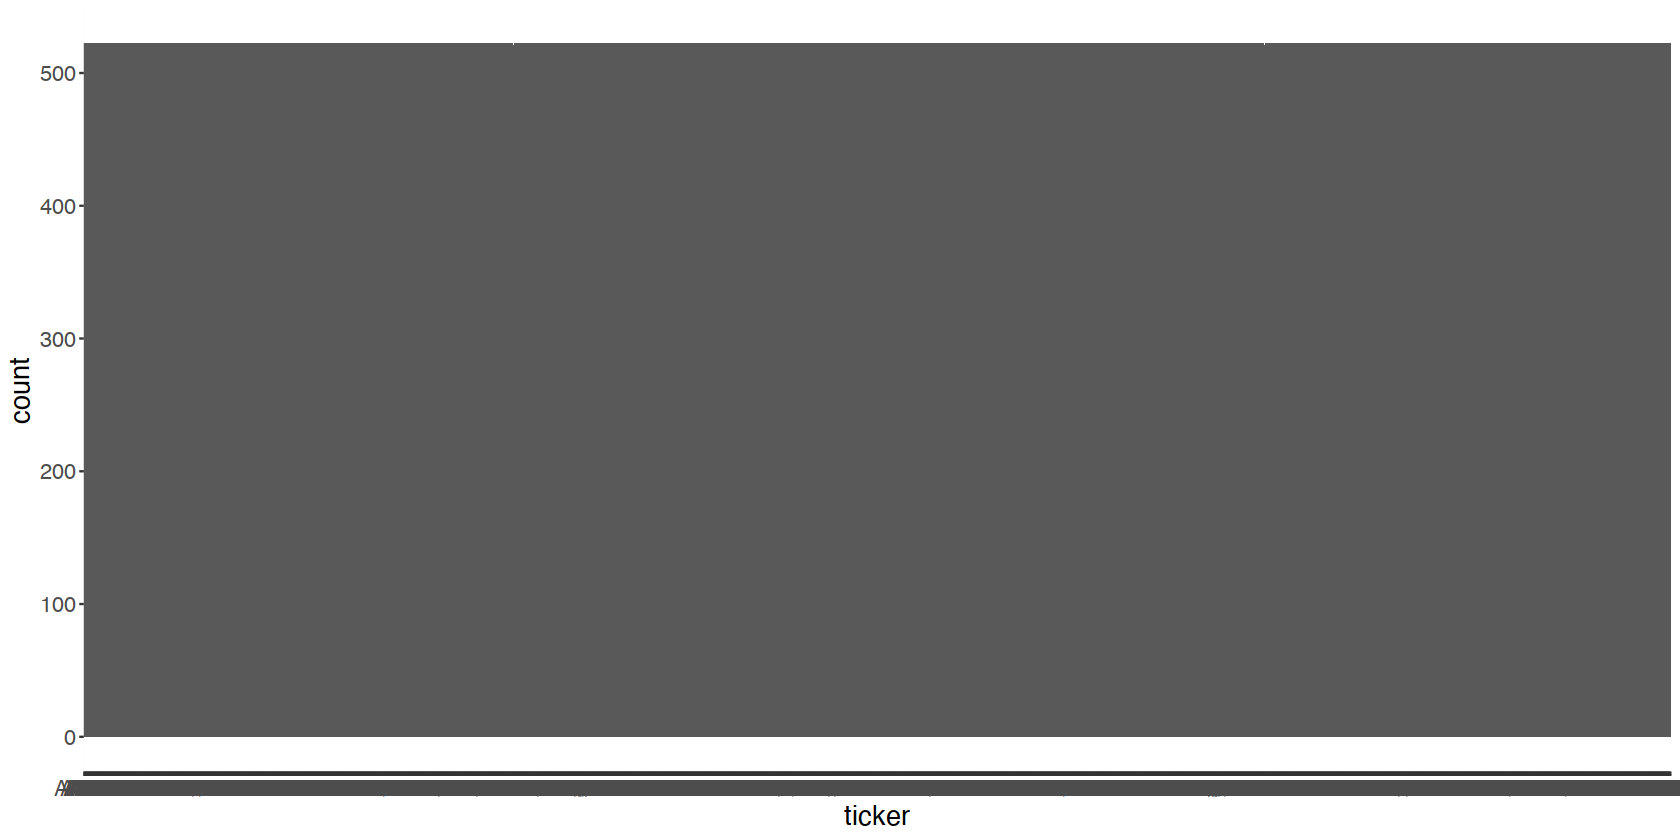

In [ ]:
# Check if history is complete for all left over time series
liquid_universe_prices %>% group_by(ticker) %>%
  summarise(count=n()) %>%
  ggplot(aes(ticker,count)) + geom_col()

In [ ]:
liquid_universe_prices %>% head

date,ticker,open,high,low,close,adjusted_close,volume,name,market_cap,sector,industry,avg_close,avg_volume
<date>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int64>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<int64>
2020-03-23,A,66.80,67.5599,62.09,63.37,62.4262,2989765,Agilent Technologies Inc (A),3.641e+10,Healthcare,Diagnostics & Research,124.9376,1708369
2020-03-24,A,65.53,68.1840,64.60,67.00,66.0021,2868917,Agilent Technologies Inc (A),3.641e+10,Healthcare,Diagnostics & Research,124.9376,1708369
2020-03-25,A,67.12,71.7900,65.11,69.00,67.9723,2628144,Agilent Technologies Inc (A),3.641e+10,Healthcare,Diagnostics & Research,124.9376,1708369
2020-03-26,A,70.00,74.4465,69.65,73.72,72.6220,3267458,Agilent Technologies Inc (A),3.641e+10,Healthcare,Diagnostics & Research,124.9376,1708369
2020-03-27,A,71.55,73.2100,70.28,70.91,69.8539,1829770,Agilent Technologies Inc (A),3.641e+10,Healthcare,Diagnostics & Research,124.9376,1708369
2020-03-30,A,71.06,73.1800,71.06,72.67,71.7699,1486203,Agilent Technologies Inc (A),3.641e+10,Healthcare,Diagnostics & Research,124.9376,1708369


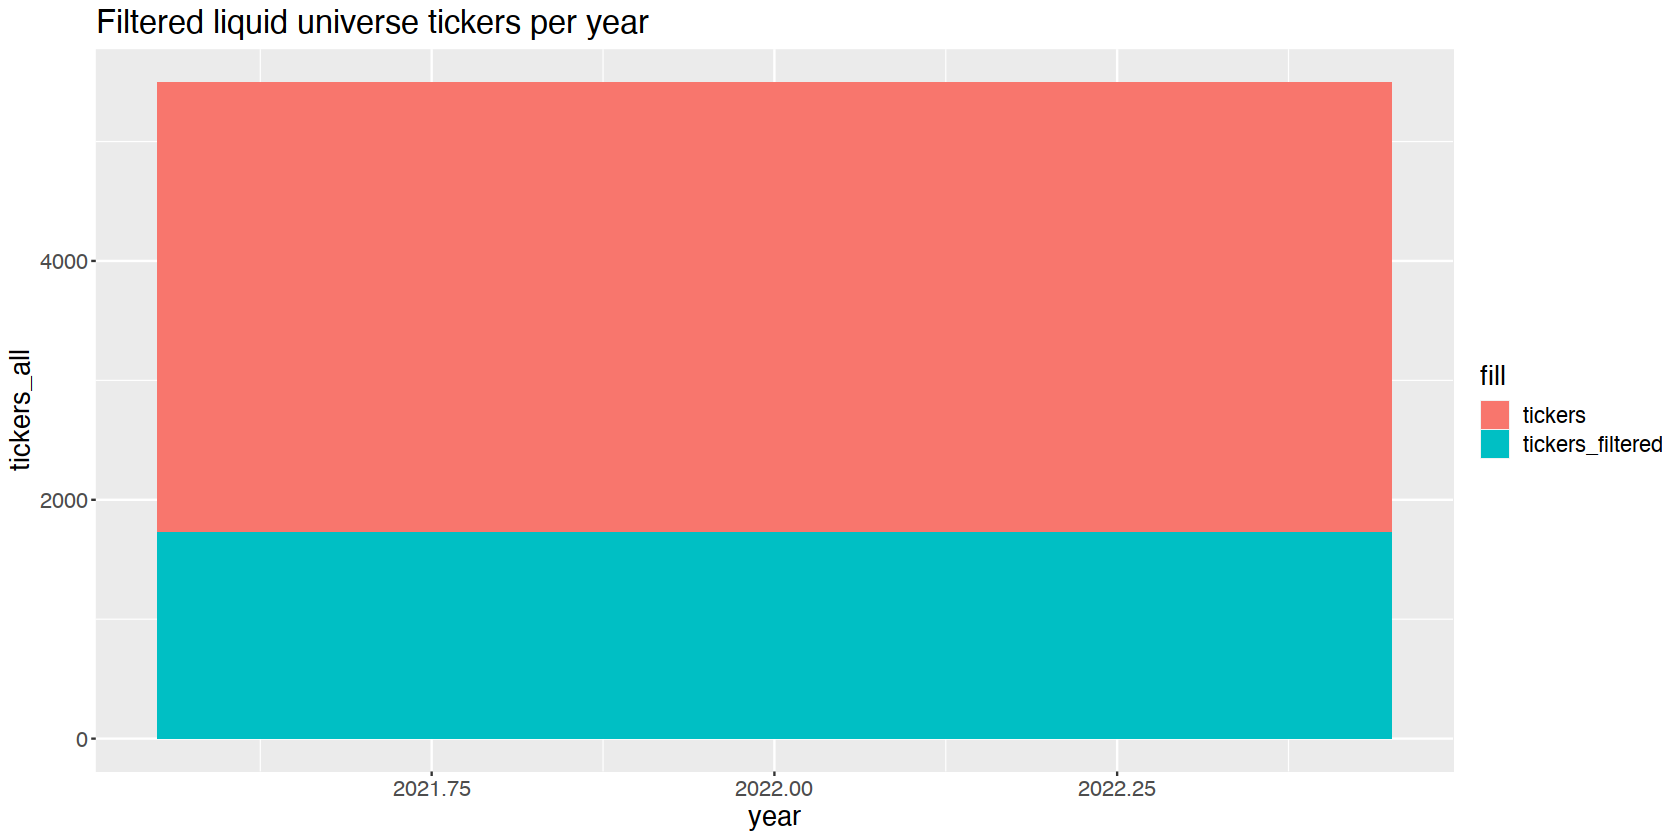

In [ ]:
# Extract number of tickers filtered/unfiltered, merge to df
tickers_all <- length(unique(prices$ticker))
tickers_filtered <- length(unique(liquid_universe_prices$ticker))
df <- data.frame(year=year(today()),tickers_all,tickers_filtered)

# Plot results
df %>%
  ggplot(aes(year)) + 
    geom_col(aes(y=tickers_all, fill="tickers")) + 
    geom_col(aes(y=tickers_filtered, fill="tickers_filtered")) +  
    ggtitle("Filtered liquid universe tickers per year")

Blue vs. red shows proportion of tickers which are liquid enough to be traded.

In 2021 1900 from around 5800 tickers were left after the filtering process.

Now we've filtered our stock universe by only having liquid stocks left. 

Let's move on.

## Create possible pair combinations
Next we're creating unique pairs of our stocks universe. Expected result:

* AAPL/AAPL -> Should be dismissed
* AAPL/MSFT -> OK
* MSFT/AAPL -> Should be dismissed

Only stocks from our liquid universe which met the criteria within the last year should be allowed.

In [ ]:
# Extract tickers from liquid universe
tickers <- unique(liquid_universe_prices$ticker)
  
str(tickers)

 chr [1:1725] "A" "AA" "AAL" "AAP" "AAPL" "AAT" "AAWW" "AB" "ABB" "ABBV" ...


In [ ]:
# Create pairs combinations
possible_pairs <- create_possible_pairs(tickers)

str(possible_pairs)

'data.frame':	1486950 obs. of  2 variables:
 $ stock1: chr  "A" "A" "A" "A" ...
 $ stock2: chr  "AA" "AAL" "AAP" "AAPL" ...


So now we have a data frame containing all possible (unique) pairs combinations (total 1.6M) for our liquid universe stocks.

## Filtering for same sector / same industry
Finally we're attaching metadata to our pairs tickers to find out which of them are from the same sector and industry. 

RW is very strict about that and is filtering out any stocks which are not from the same sector AND universe. (Side note: AAPL / MSFT are not!).

In [ ]:
pairs_by_sector_industry <- filter_by_sector_industry(possible_pairs)

str(pairs_by_sector_industry)

tibble [1,486,950 × 5] (S3: tbl_df/tbl/data.frame)
 $ pair            : int [1:1486950] 1 2 3 4 5 6 7 8 9 10 ...
 $ stock1          : chr [1:1486950] "A" "A" "A" "A" ...
 $ stock2          : chr [1:1486950] "AA" "AAL" "AAP" "AAPL" ...
 $ is_same_sector  : logi [1:1486950] FALSE FALSE FALSE FALSE FALSE FALSE ...
 $ is_same_industry: logi [1:1486950] FALSE FALSE FALSE FALSE FALSE FALSE ...


In [ ]:
same_sector <- pairs_by_sector_industry %>% 
  group_by(is_same_sector) %>%
  rename(is_same = is_same_sector) %>%
  summarise(is_same_sector = n())

same_industry <- pairs_by_sector_industry %>% 
  group_by(is_same_industry) %>%
  rename(is_same = is_same_industry) %>%
  summarise(is_same_industry = n())

is_same <- same_sector %>% left_join(same_industry, by="is_same")
is_same

is_same,is_same_sector,is_same_industry
<lgl>,<int>,<int>
FALSE,1327960,1466755
TRUE,158990,20195


From our total universe of 1.0M there are around 20K left which are from the same industry + sector.

In [ ]:
pairs_preselection <- pairs_by_sector_industry %>% 
  select(-pair) %>%
  filter(is_same_sector==1 & is_same_industry==1)

str(pairs_preselection)
pairs_preselection %>% head

tibble [20,195 × 4] (S3: tbl_df/tbl/data.frame)
 $ stock1          : chr [1:20195] "A" "A" "A" "A" ...
 $ stock2          : chr [1:20195] "CDNA" "CRL" "DGX" "DHR" ...
 $ is_same_sector  : logi [1:20195] TRUE TRUE TRUE TRUE TRUE TRUE ...
 $ is_same_industry: logi [1:20195] TRUE TRUE TRUE TRUE TRUE TRUE ...


stock1,stock2,is_same_sector,is_same_industry
<chr>,<chr>,<lgl>,<lgl>
A,CDNA,TRUE,TRUE
A,CRL,TRUE,TRUE
A,DGX,TRUE,TRUE
A,DHR,TRUE,TRUE
A,EXAS,TRUE,TRUE
A,FLGT,TRUE,TRUE


Let's have some quality check..

In [ ]:
t <- c("A","CDNA","CRL","DGX","DHR","EXAS","FLGT")
fundamentals %>% filter(ticker %in% t)

name,ticker,market_cap,sector,industry
<chr>,<chr>,<dbl>,<chr>,<chr>
CareDx Inc (CDNA),CDNA,1.6210e+09,Healthcare,Diagnostics & Research
Charles River Laboratories International Inc (CRL),CRL,1.3870e+10,Healthcare,Diagnostics & Research
Quest Diagnostics Inc (DGX),DGX,1.6050e+10,Healthcare,Diagnostics & Research
Danaher Corp (DHR),DHR,1.9236e+11,Healthcare,Diagnostics & Research
Exact Sciences Corp (EXAS),EXAS,1.0570e+10,Healthcare,Diagnostics & Research
Fulgent Genetics Inc (FLGT),FLGT,1.7070e+09,Healthcare,Diagnostics & Research
Agilent Technologies Inc (A),A,3.6410e+10,Healthcare,Diagnostics & Research


Yeah.. for what I filtered it did the right thing..

So let's move on

# Create synthetic spreads

### Calculate spread

In [ ]:
spreads <- calc_spreads(pairs_preselection, liquid_universe_prices, 
  close_var="adjusted_close", date_from, date_to)
spreads %>% head
  

pair,date,ticker_1,ticker_2,close_1,close_2,spreadclose,ratiospread,sma,roll_sd,zscore
<chr>,<date>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
A/CDNA,2020-05-01,A,CDNA,73.2908,26.85,-1.0041693,2.729639,-1.181411,0.08856635,2.0012359
A/CDNA,2020-05-04,A,CDNA,73.6364,28.89,-0.9356440,2.548854,-1.163183,0.09965186,2.2833414
A/CDNA,2020-05-05,A,CDNA,75.4240,29.45,-0.9404316,2.561087,-1.149798,0.11066613,1.8918708
A/CDNA,2020-05-06,A,CDNA,76.9054,28.35,-0.9979491,2.712713,-1.136262,0.11191131,1.2359170
A/CDNA,2020-05-07,A,CDNA,77.5276,29.27,-0.9740709,2.648705,-1.122281,0.11391741,1.3010334
A/CDNA,2020-05-08,A,CDNA,78.7227,28.25,-1.0248381,2.786644,-1.110401,0.11088047,0.7716706


In [ ]:
spreads %>% write.table("export/spreads.csv", quote=FALSE, sep=",", row.names=FALSE)

### Visualization of spread

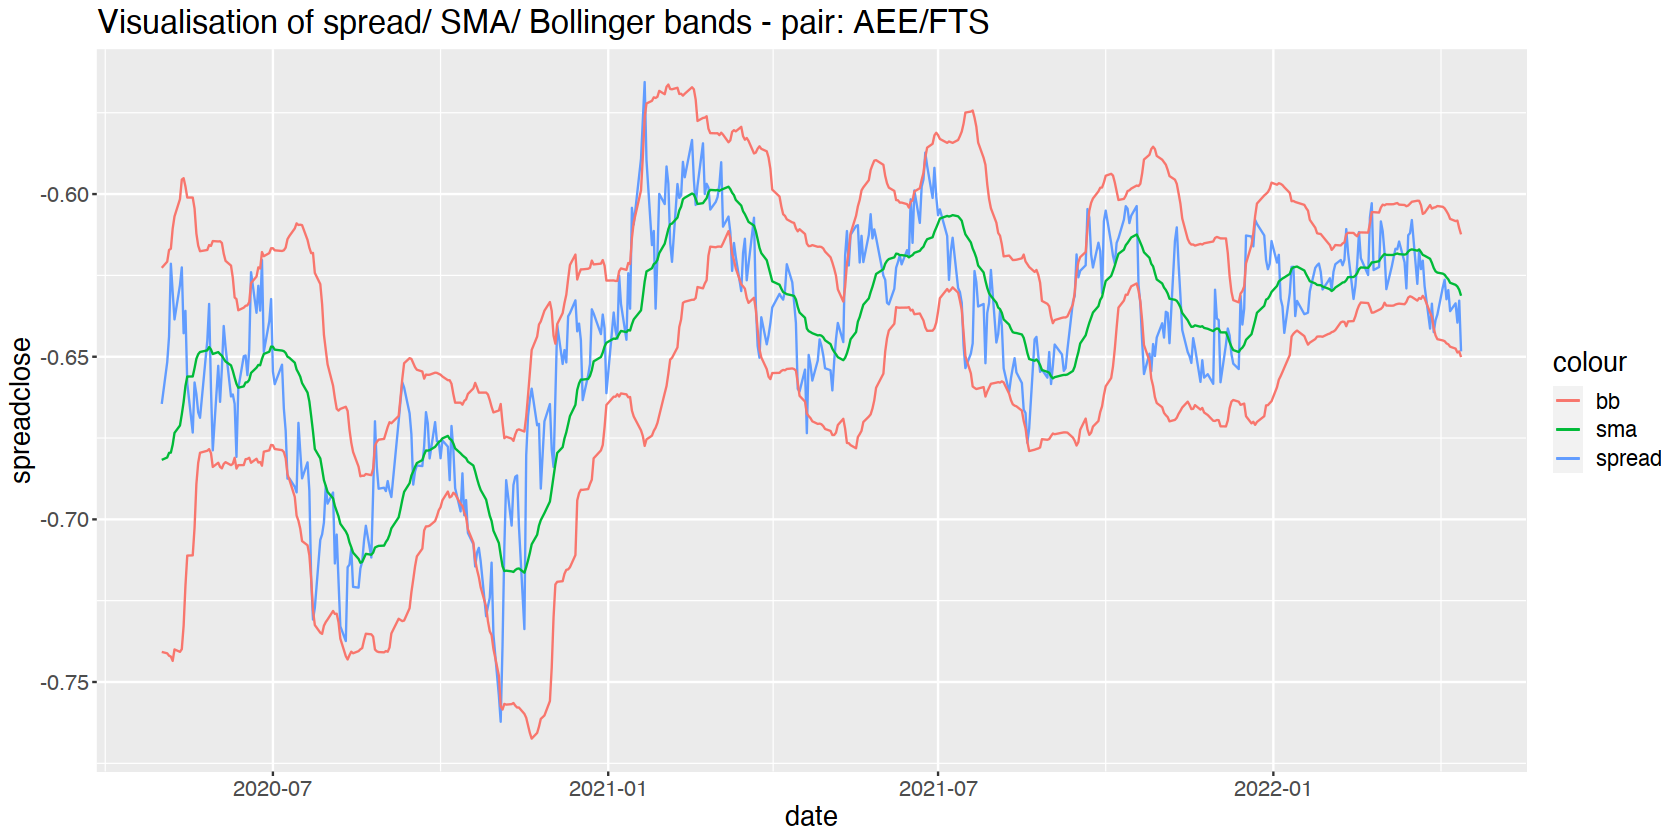

In [ ]:
pair <- "AEE/FTS"
plot_spread(spreads,pair)

When spread crosses the borders of the bollinger bands we would enter a long/short spread trade.

Let's see how this looks like for zscore:

## Visualization of zscore

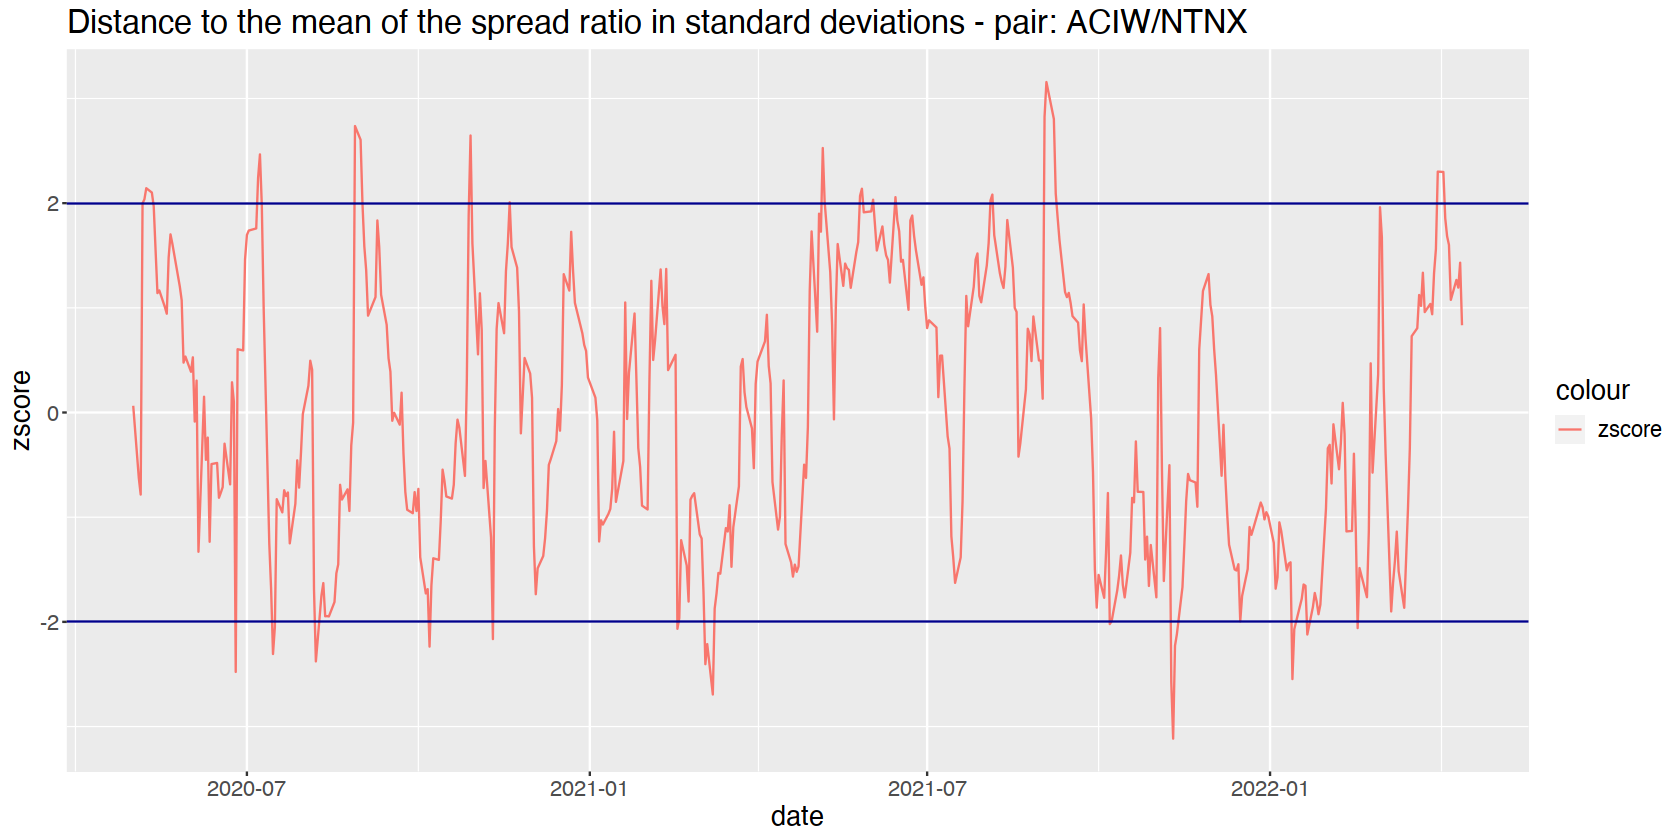

In [ ]:
pair <- "ACIW/NTNX"
plot_zscore(spreads,pair)

# Linear strategy returns (LSR) feature
Now we are going to create a feature called "Linear Strategy Return" (LSR) which is the returns of a trading strategy that holds a position in inverse proportion to the 20 day zscore of the spread.

**We assume that past performance is indicative for future performance of pairs.**

It would be:
- Very long next day if zscore < -3
- Slightly long next day if zscore = -0.5
- Flat if zscore = 0
- Slightly short next day if zscore = 0.5
- Very short next day if zscore > 3
 
## Create LSR Backtest
 
We want to:
1. Calculate daily log returns
2. Calculate the weight to hold as the lagged zscore
3. Multiply the zscore by the log returns to get daily backtest strategy returns for each pair

## Calculate feature

In [ ]:
lsr <- calc_lsr(spreads)
lsr %>% head

pair,date,ticker_1,ticker_2,close_1,close_2,spreadclose,ratiospread,sma,roll_sd,zscore,log_ret,lsr
<chr>,<date>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
A/CDNA,2020-05-04,A,CDNA,73.6364,28.89,-0.9356440,2.548854,-1.163183,0.09965186,2.2833414,-0.068525314,-0.13713532
A/CDNA,2020-05-05,A,CDNA,75.4240,29.45,-0.9404316,2.561087,-1.149798,0.11066613,1.8918708,0.004787662,0.01093187
A/CDNA,2020-05-06,A,CDNA,76.9054,28.35,-0.9979491,2.712713,-1.136262,0.11191131,1.2359170,0.057517448,0.10881558
A/CDNA,2020-05-07,A,CDNA,77.5276,29.27,-0.9740709,2.648705,-1.122281,0.11391741,1.3010334,-0.023878164,-0.02951143
A/CDNA,2020-05-08,A,CDNA,78.7227,28.25,-1.0248381,2.786644,-1.110401,0.11088047,0.7716706,0.050767192,0.06604981
A/CDNA,2020-05-11,A,CDNA,80.2633,30.03,-0.9831156,2.672771,-1.095969,0.10750665,1.0497369,-0.041722495,-0.03219602


In [ ]:
lsr %>% write.table("export/lsr_feature.csv", row.names=FALSE, sep=",", quote=FALSE)

## Rank results
Now we're ranking the results by the past pairs performance.

RW James ranked the results by calculating a sharpe ratio like `sum(lsr)/sd(lsr) `. I'm a little sceptical about that, because there might be pairs ranked high with very low vol of returns, but too low returns in absolute terms. Instead I'm ranking the pairs by their sum of past returns -> `sum(lsr)`.

In [ ]:
lsr_score <- get_lsr_score(lsr, filter_fct="total_ret") # set "sharpe" for sum(lsr)/sd(lsr) ranking

### Top 10 results
Let's have a look which pairs had the highest linear strategy return in the past year:

In [ ]:
lsr_score %>% 
  head(10)

pair,lsr,lsr_rank,lsr_perc
<chr>,<dbl>,<int>,<int>
PDD/QRTEA,5.578885,1,1
JD/QRTEA,5.457132,2,1
BABA/QRTEA,5.259139,3,1
EVBG/LSPD,4.914958,4,1
EVBG/RNG,4.705111,5,1
CYTK/XENE,4.621717,6,1
BCRX/BEAM,4.568288,7,1
BEAM/NTLA,4.433816,8,1
MDB/SUMO,4.406894,9,1


## Sense check
We're picking one example of the top 10 list -> expect a positive return curve over the past period, hopefully we will see that.

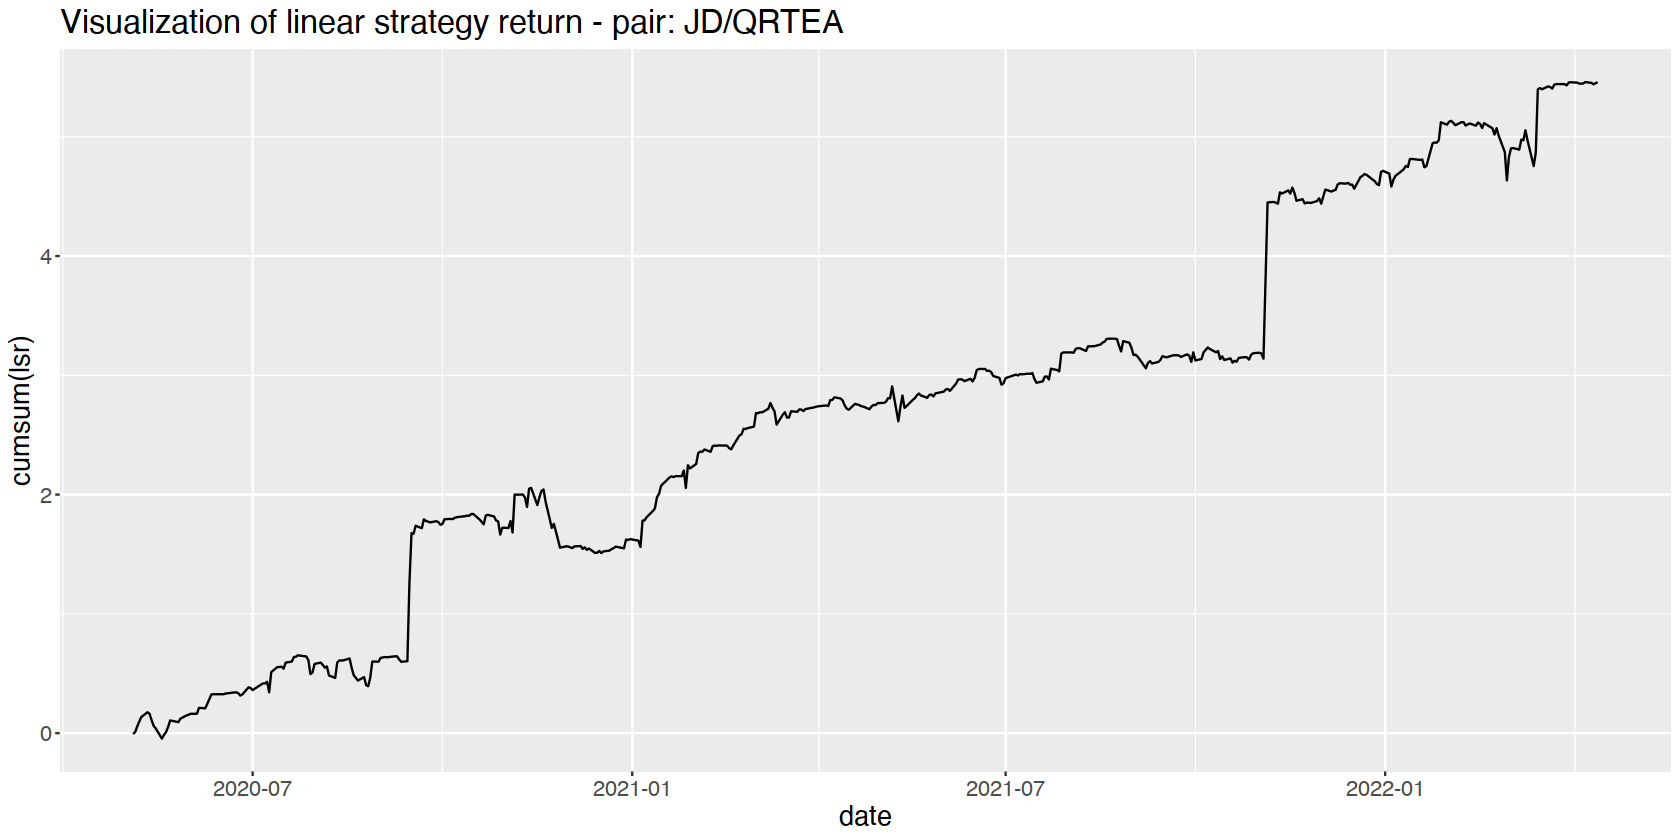

In [ ]:
pair <- "JD/QRTEA"
plot_lsr(lsr,pair)

Looks good..

# Euclidean distance factor feature
Now we are going to create a feature called “Euclidean Distance (ED)” which is a measure of how closely prices of stocks in a pair stay together during the month.

This is very useful if used in combination with the LSR factor, because it tends to remove wild outliers.

We want to:
1. Normalize the price of each stock in each pair to zero at the start of each month
2. For each month, sum the squared difference of these normalized prices.
  
The output will be a table with
+ startofmonth 
+ stock1
+ stock2
+ sum of squared normalise price distances


## Calculate feature

In [ ]:
edf <- calc_edf(spreads)
edf %>% write.table("export/edf_feature.csv", quote=FALSE, sep=",", row.names=FALSE)

`summarise()` has grouped output by 'pair'. You can override using the
`.groups` argument.


## Rank results

In [ ]:
edf_score <- get_edf_score(edf)

### Top 10 results

In [ ]:
edf_score %>%
  head(10)

pair,edf,edf_rank,edf_perc
<chr>,<dbl>,<int>,<int>
GOOG/GOOGL,0.0005335755,1,1
LSXMA/LSXMK,0.0009064073,2,1
LBTYA/LBTYK,0.0014191794,3,1
FOX/FOXA,0.0017693409,4,1
Z/ZG,0.0029099054,5,1
PAA/PAGP,0.0031732864,6,1
NWS/NWSA,0.0036552173,7,1
UA/UAA,0.0041370253,8,1
CPT/MAA,0.0042928749,9,1


## Sense check
We're picking one example from our top 10 list, hope two see two time series of tickers moving very similar. 

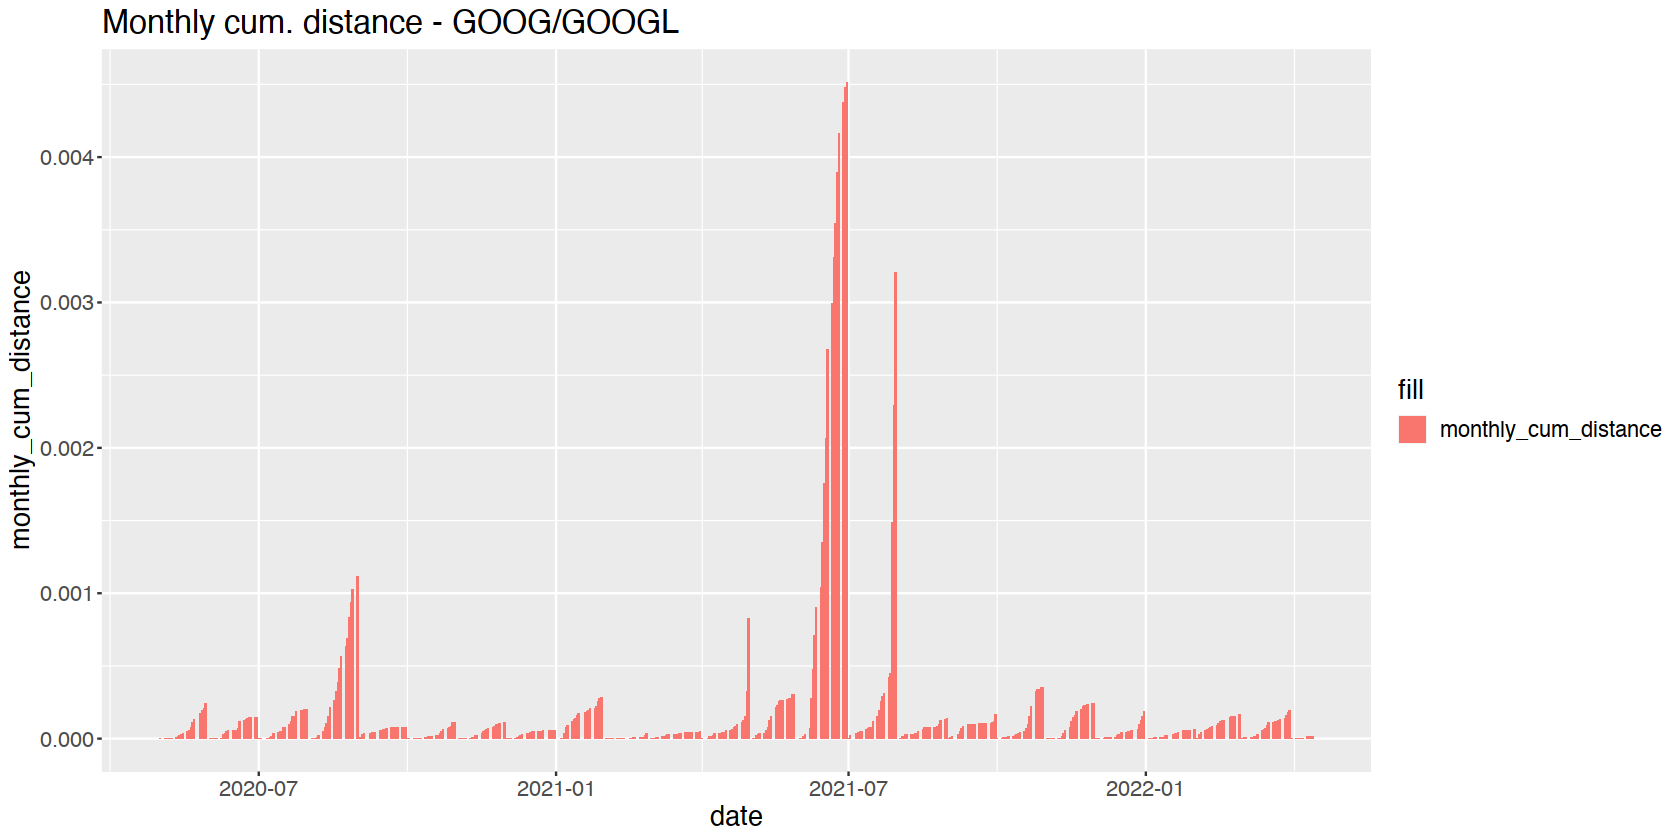

In [ ]:
pair <- "GOOG/GOOGL"
plot_dist(spreads,pair)

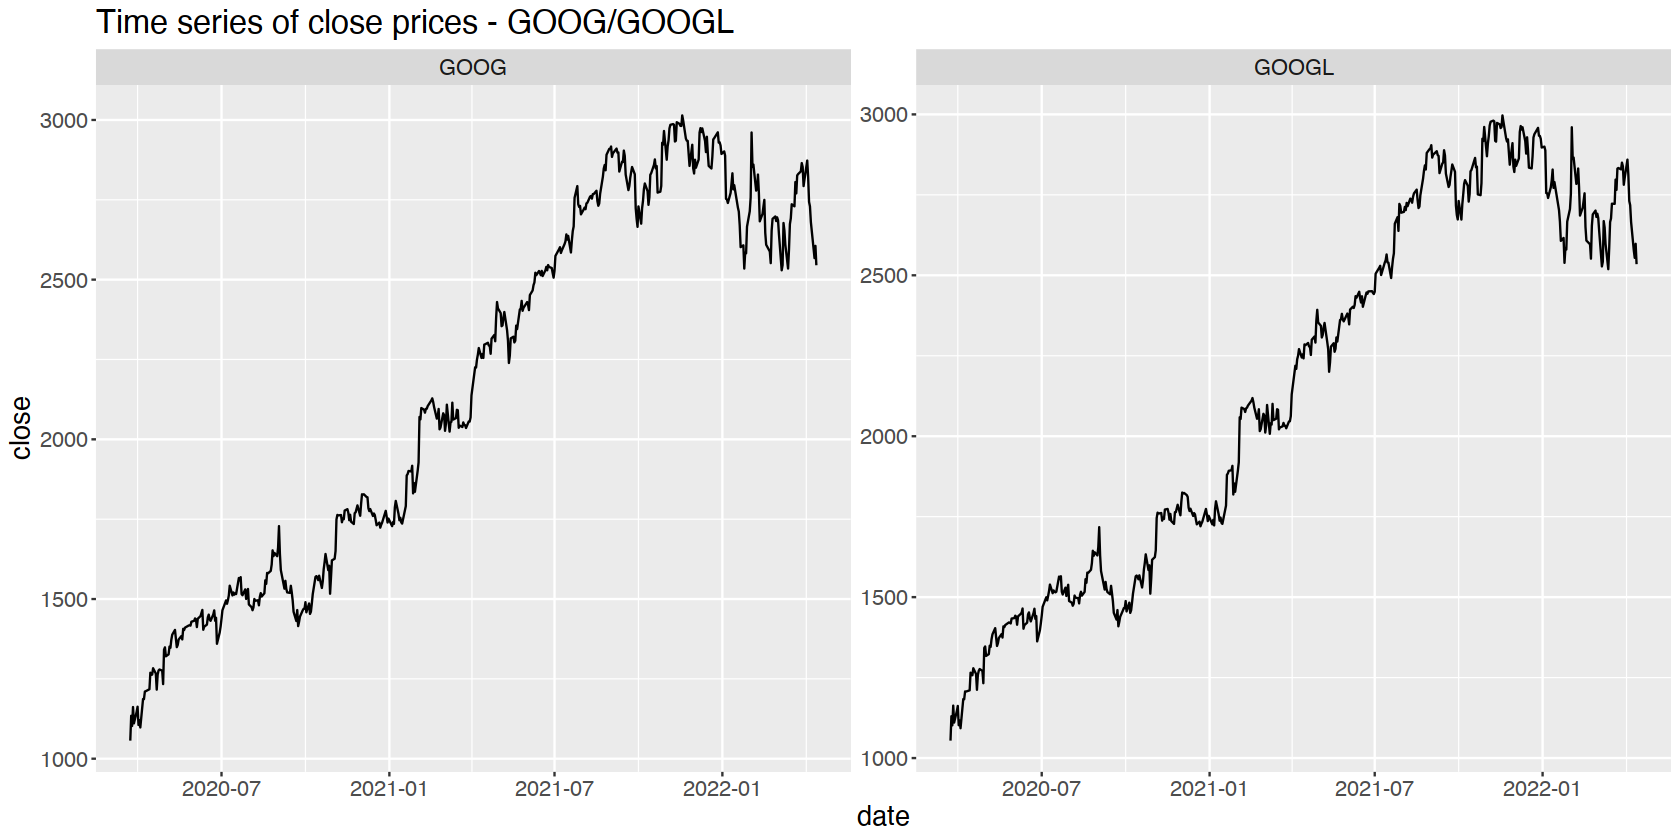

In [ ]:
pair <- "GOOG/GOOGL"
plot_timeseries(liquid_universe_prices,pair)


Yeah..obviously they do.

# Graphical lasso 
Last, we create a feature called Graphical lasso. Basically, it creates an inverse covariance matrix over all possible pairs. 

## Calculate feature

As code base I took the functions from Robotkris and adapted them.

https://github.com/RWLab/equity-stat-arb/blob/main/pairs-trading-pipeline/graphical_lasso/build/calculate_lasso.R

In [ ]:
lasso_approve <- calc_cov(liquid_universe_prices, pairs_preselection) %>%
  get_pcorrs() %>% make_lasso_feature()

Attempting graphical lasso on covariance matrix of dimensions 1716
Attempting graphical lasso on covariance matrix of dimensions 1716
[1] "2022-04-27 08:49:28 CEST"
Done at 2022-04-27 08:49:35


# Final results

## Create combo score
We're now ranking the pairs by lsr score + edf score percentile. Lowest percentile means best results, so we're looking for the pairs with the highest co-movement /lowest distance (EDF feature) and the highest past spread returns (LSR feature). Then we're filtering out pairs not meeting the graphical lasso feature requirements. 

In [ ]:
combo_score <- get_combo_score(lsr_score,edf_score,lasso_approve,fundamentals)

## Top 10 pairs
Let's have a look at the final results, these are our final candidates:

In [ ]:
# Plotting the top10
combo_score %>% head(100) %>% mutate(rank=row_number())

# Write to file
combo_score %>% write.table(paste0("export/pairs_longlist_",year(today()),".csv"), row.names=FALSE, sep=",")

pair,name_1,name_2,sector_1,industry_1,lsr_rank,lsr_perc,edf_rank,edf_perc,lasso_approved,combo_score,rank
<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>,<lgl>,<dbl>,<int>
CADE/ONB,Cadence Bank (CADE),Old National Bancorp (ONB),Financial Services,Banks - Regional,1107,6,192,1,TRUE,649.5,1
NTRS/SEIC,Northern Trust Corp (NTRS),SEI Investments Co (SEIC),Financial Services,Asset Management,1349,7,665,4,TRUE,1007.0,2
H/MAR,Hyatt Hotels Corp (H),Marriott International Inc (MAR),Consumer Cyclical,Lodging,2113,11,150,1,TRUE,1131.5,3
FFBC/FNB,First Financial Bancorp (FFBC),F N B Corp (FNB),Financial Services,Banks - Regional,2598,13,90,1,TRUE,1344.0,4
DRH/PK,Diamondrock Hospitality Co (DRH),Park Hotels & Resorts Inc (PK),Real Estate,REIT - Hotel & Motel,961,5,1851,10,TRUE,1406.0,5
PAYC/PCTY,Paycom Software Inc (PAYC),Paylocity Holding Corp (PCTY),Technology,Software - Application,1994,10,908,5,TRUE,1451.0,6
FFBC/ONB,First Financial Bancorp (FFBC),Old National Bancorp (ONB),Financial Services,Banks - Regional,2531,13,419,3,TRUE,1475.0,7
FNB/ONB,F N B Corp (FNB),Old National Bancorp (ONB),Financial Services,Banks - Regional,2783,14,210,2,TRUE,1496.5,8
BXMT/LADR,Blackstone Mortgage Trust Inc (BXMT),Ladder Capital Corp (LADR),Real Estate,REIT - Mortgage,2837,15,243,2,TRUE,1540.0,9


## Final sense check
Let's have a final sense check and plot time series of close prices for each ticker, spread, Zscore, monthly distance and linear strategy returns for some of the top pairs:

In [ ]:
pairs <- unique(combo_score$pair[1:10])
pairs

[1] "CADE/ONB"  "NTRS/SEIC" "H/MAR"     "FFBC/FNB"  "DRH/PK"    "PAYC/PCTY"
 [7] "FFBC/ONB"  "FNB/ONB"   "BXMT/LADR" "BPOP/FBP"

### Pair #1

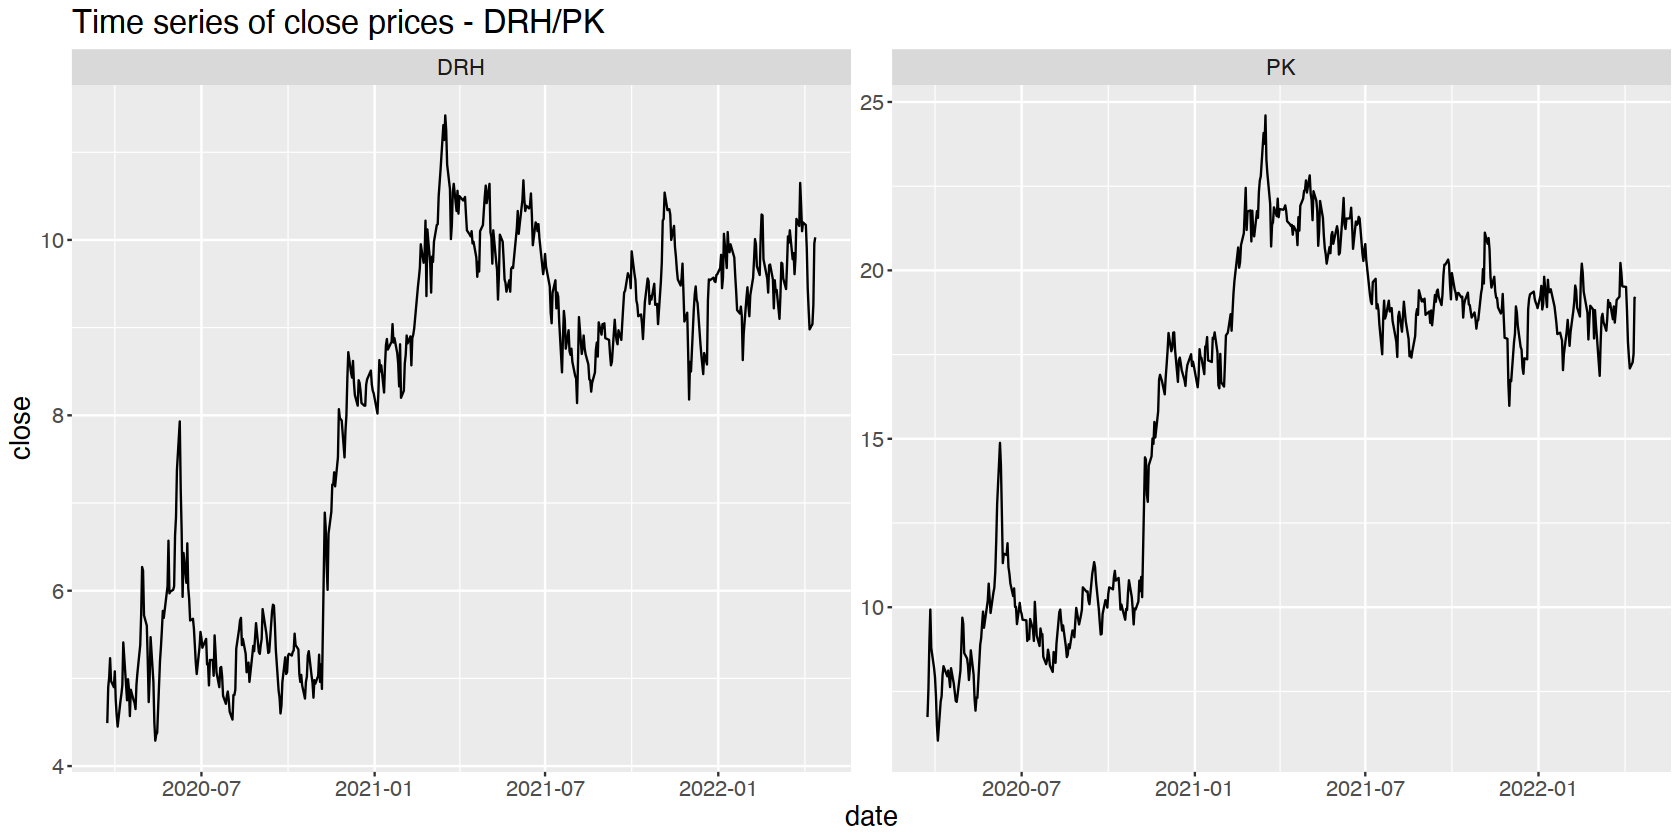

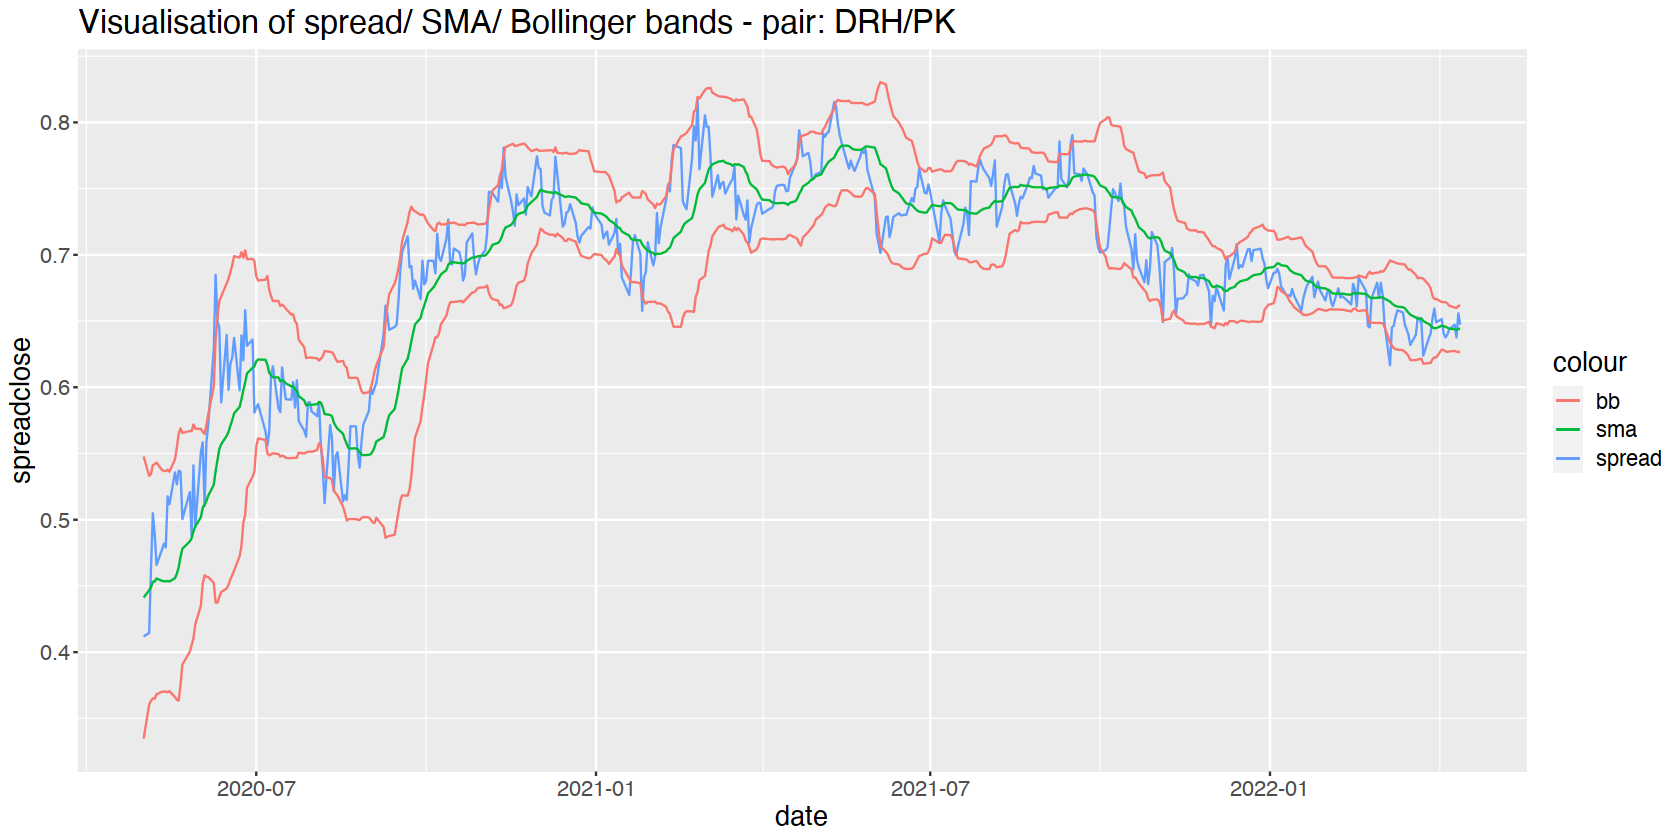

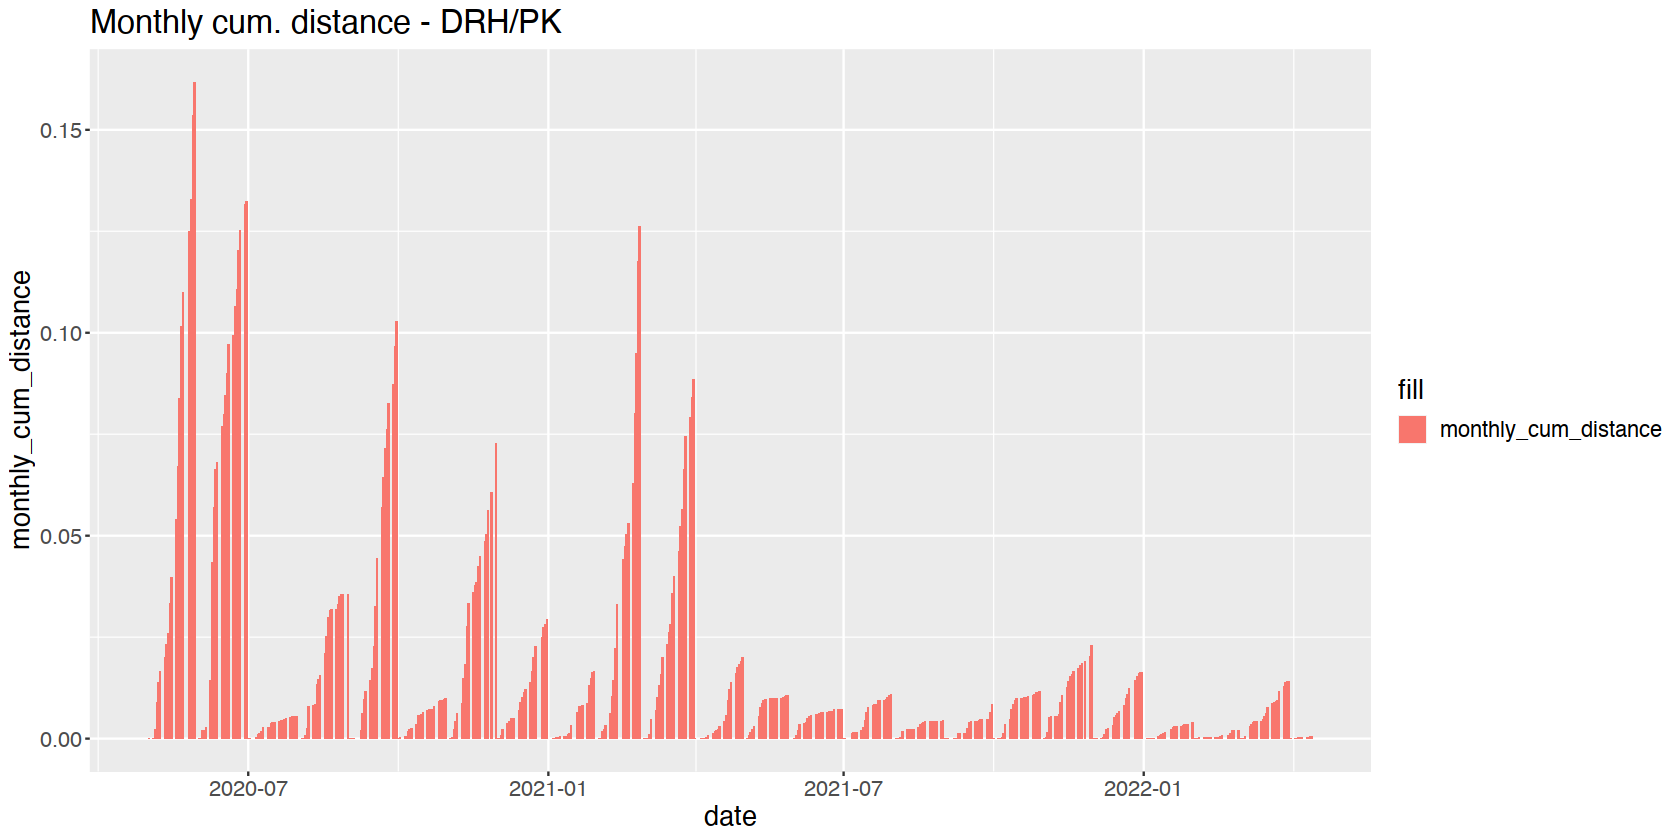

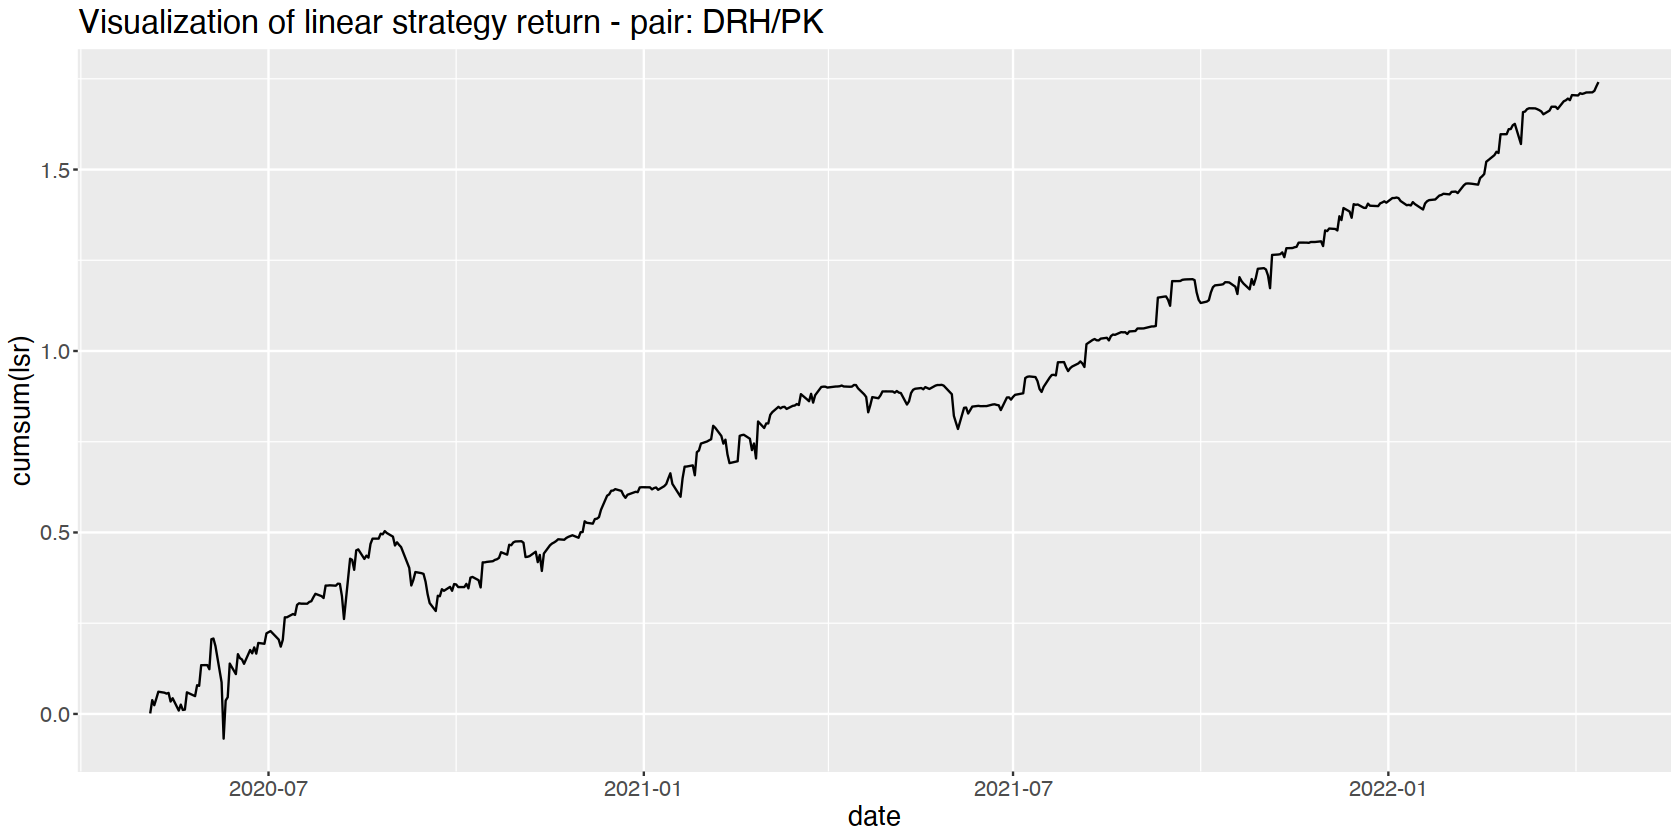

In [ ]:
pair <- pairs[1]
plot_timeseries(liquid_universe_prices,pair)
plot_spread(spreads,pair)
#plot_zscore(spreads,pair)
plot_dist(spreads,pair)
plot_lsr(lsr,pair)

### Pair #2

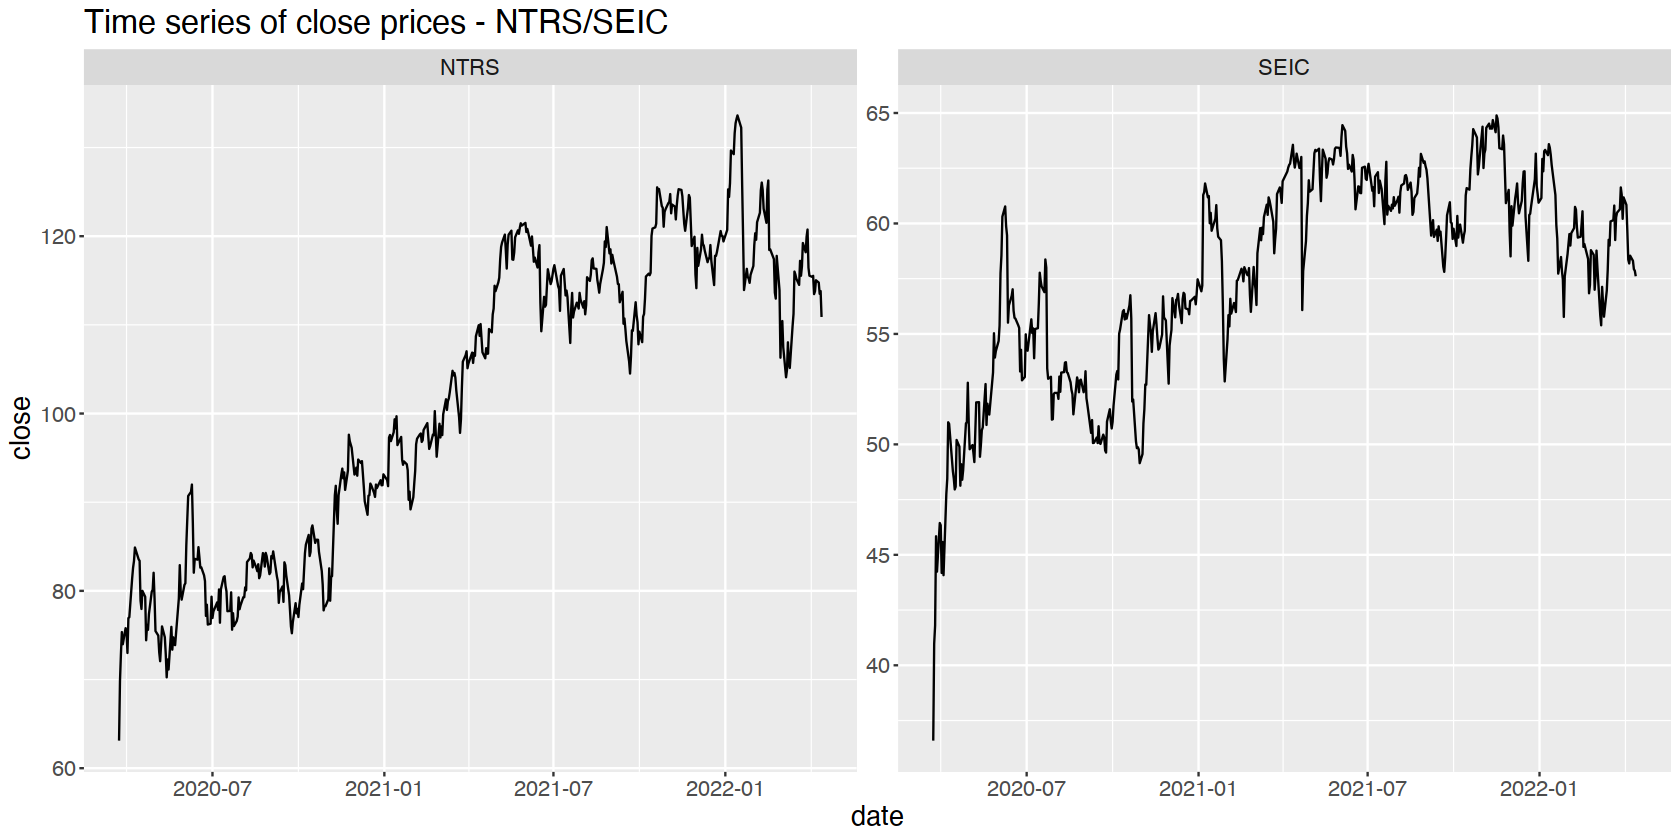

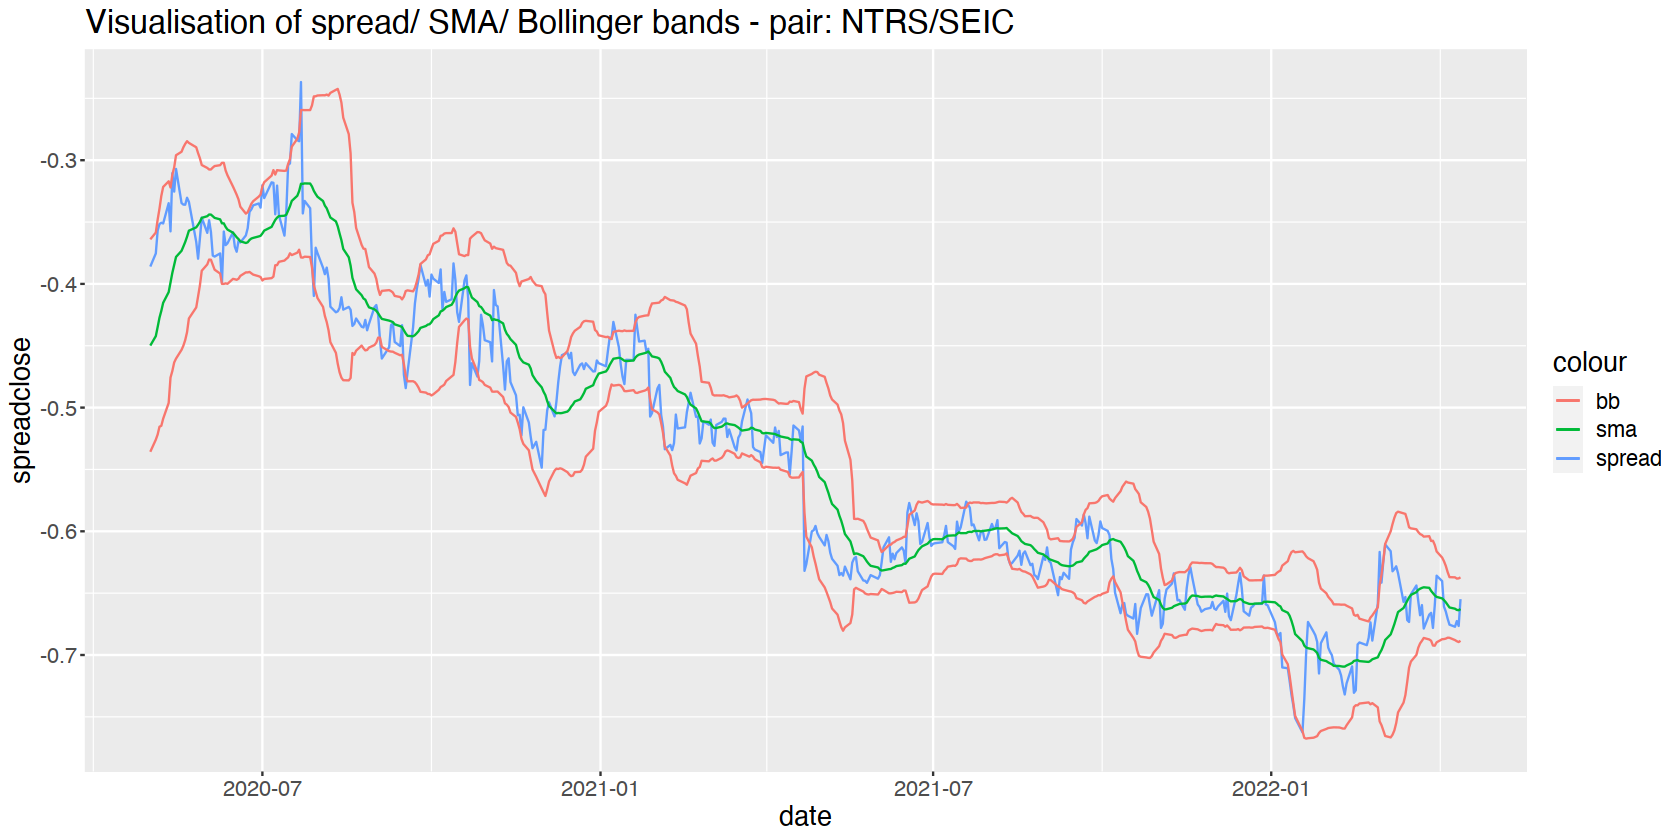

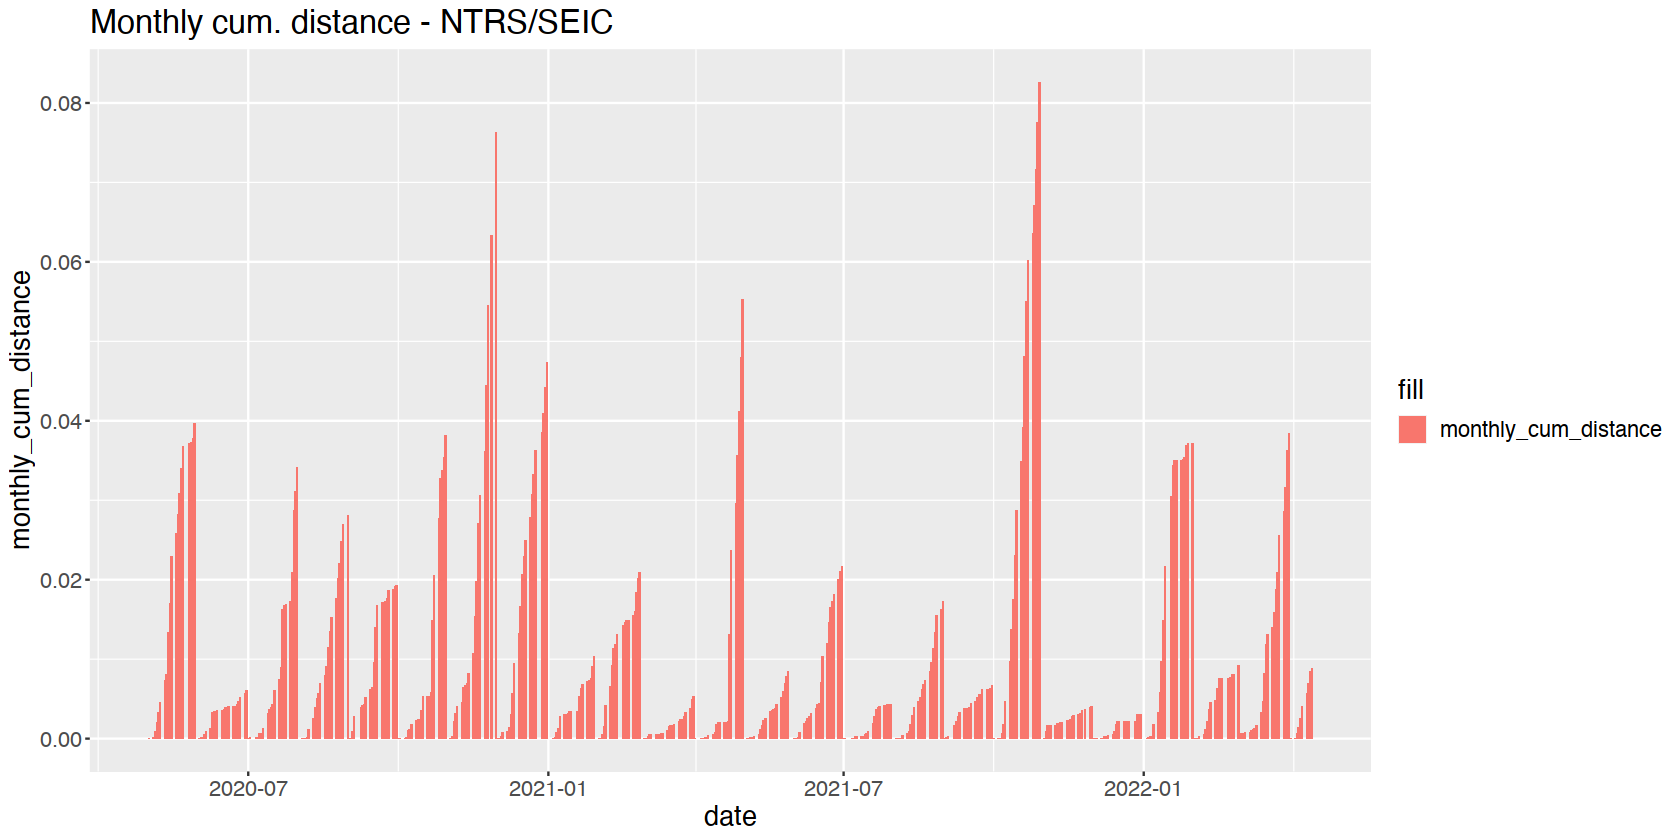

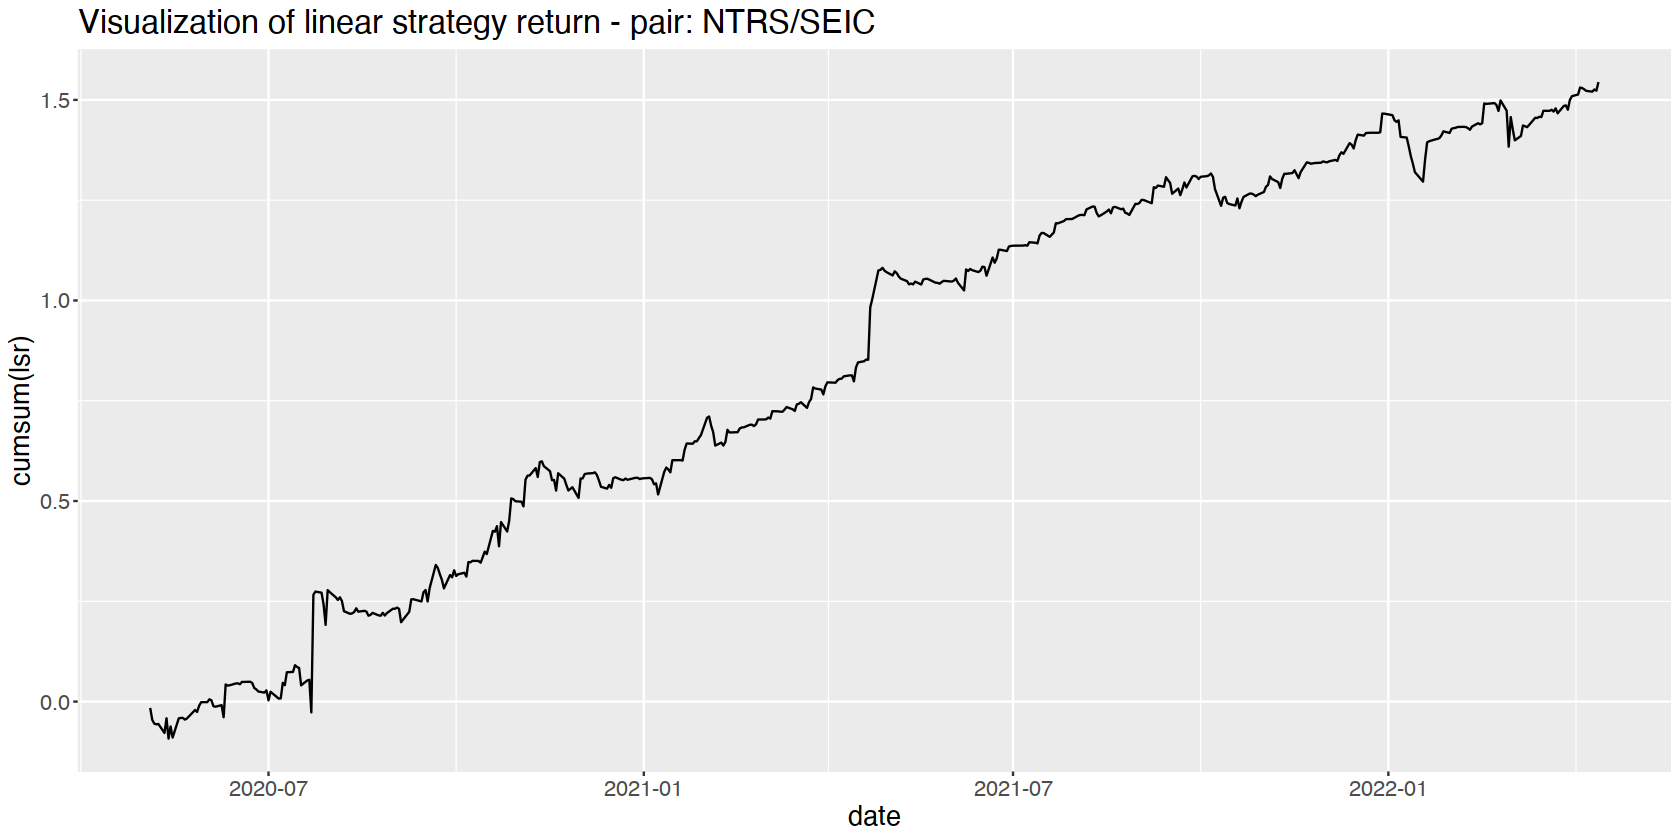

In [ ]:
pair <- pairs[2]
plot_timeseries(liquid_universe_prices,pair)
plot_spread(spreads,pair)
#plot_zscore(spreads,pair)
plot_dist(spreads,pair)
plot_lsr(lsr,pair)

### Pair #3

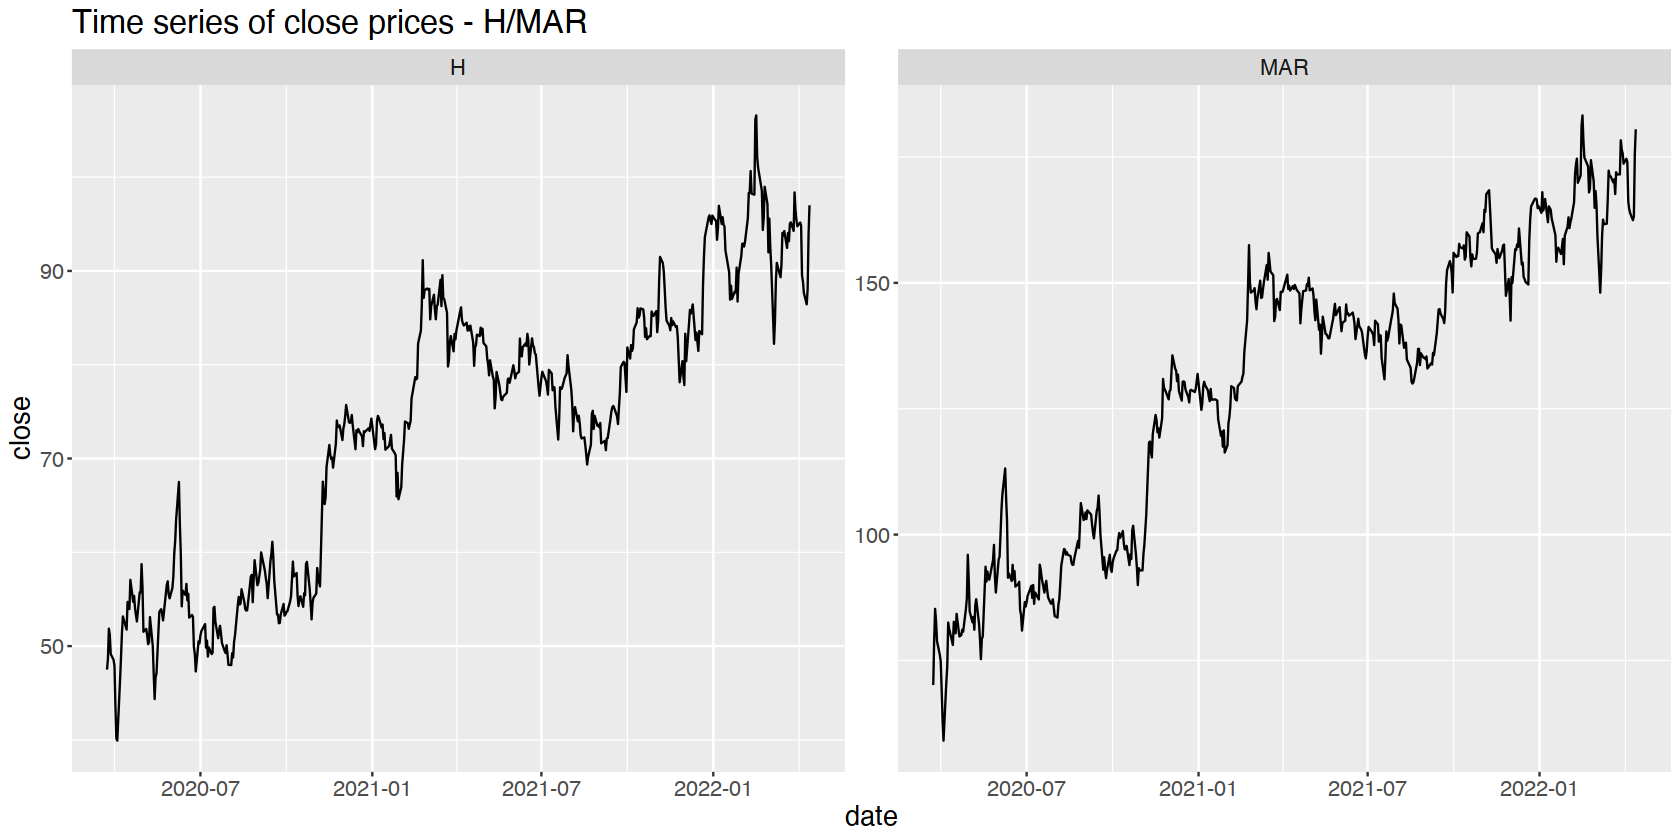

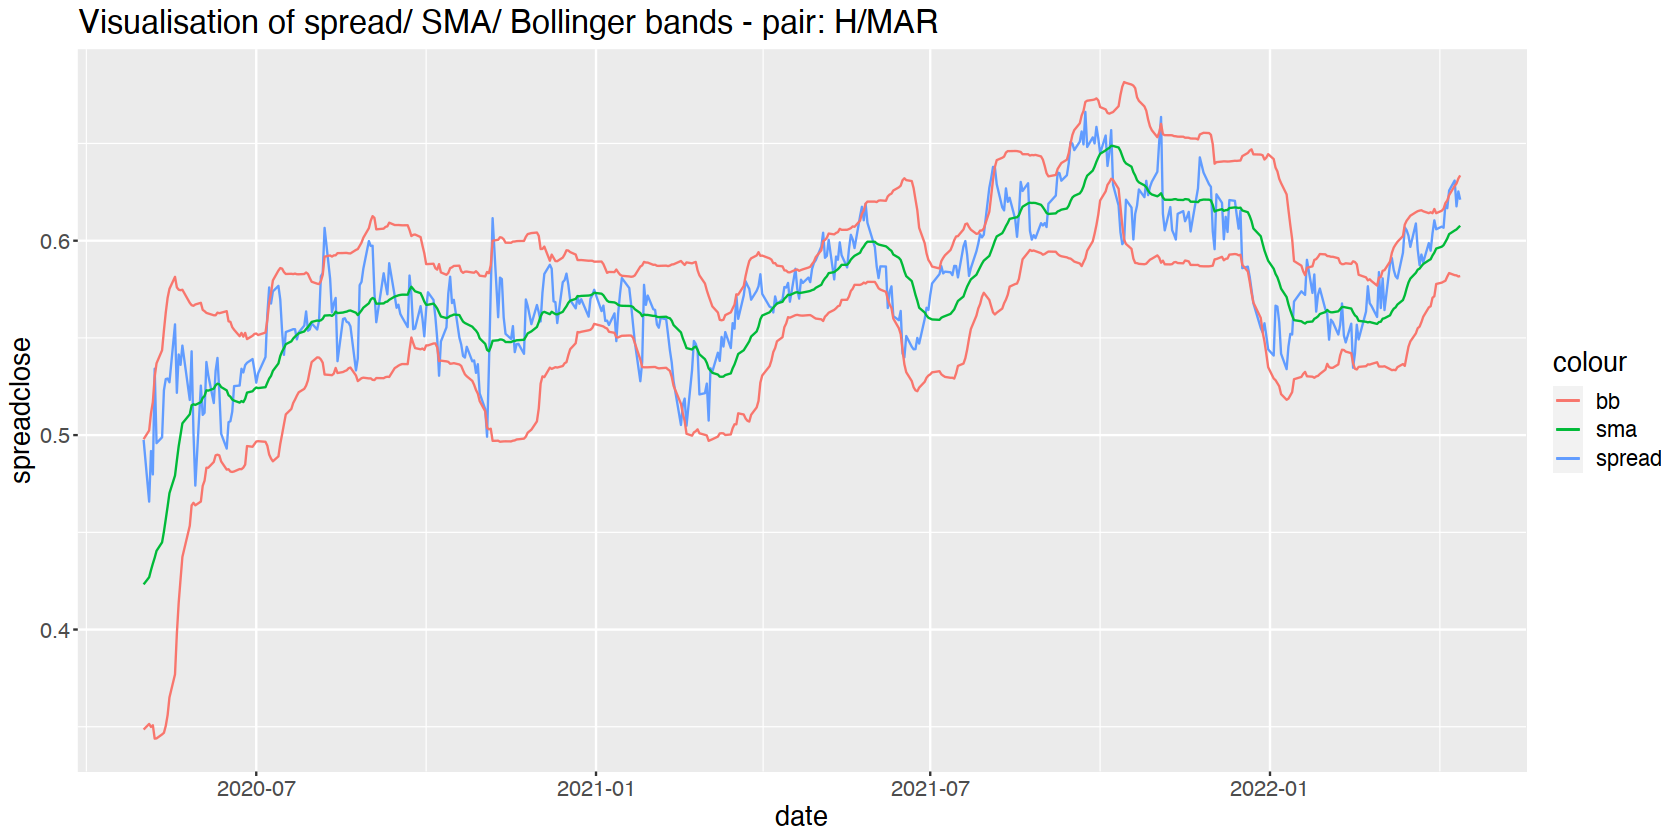

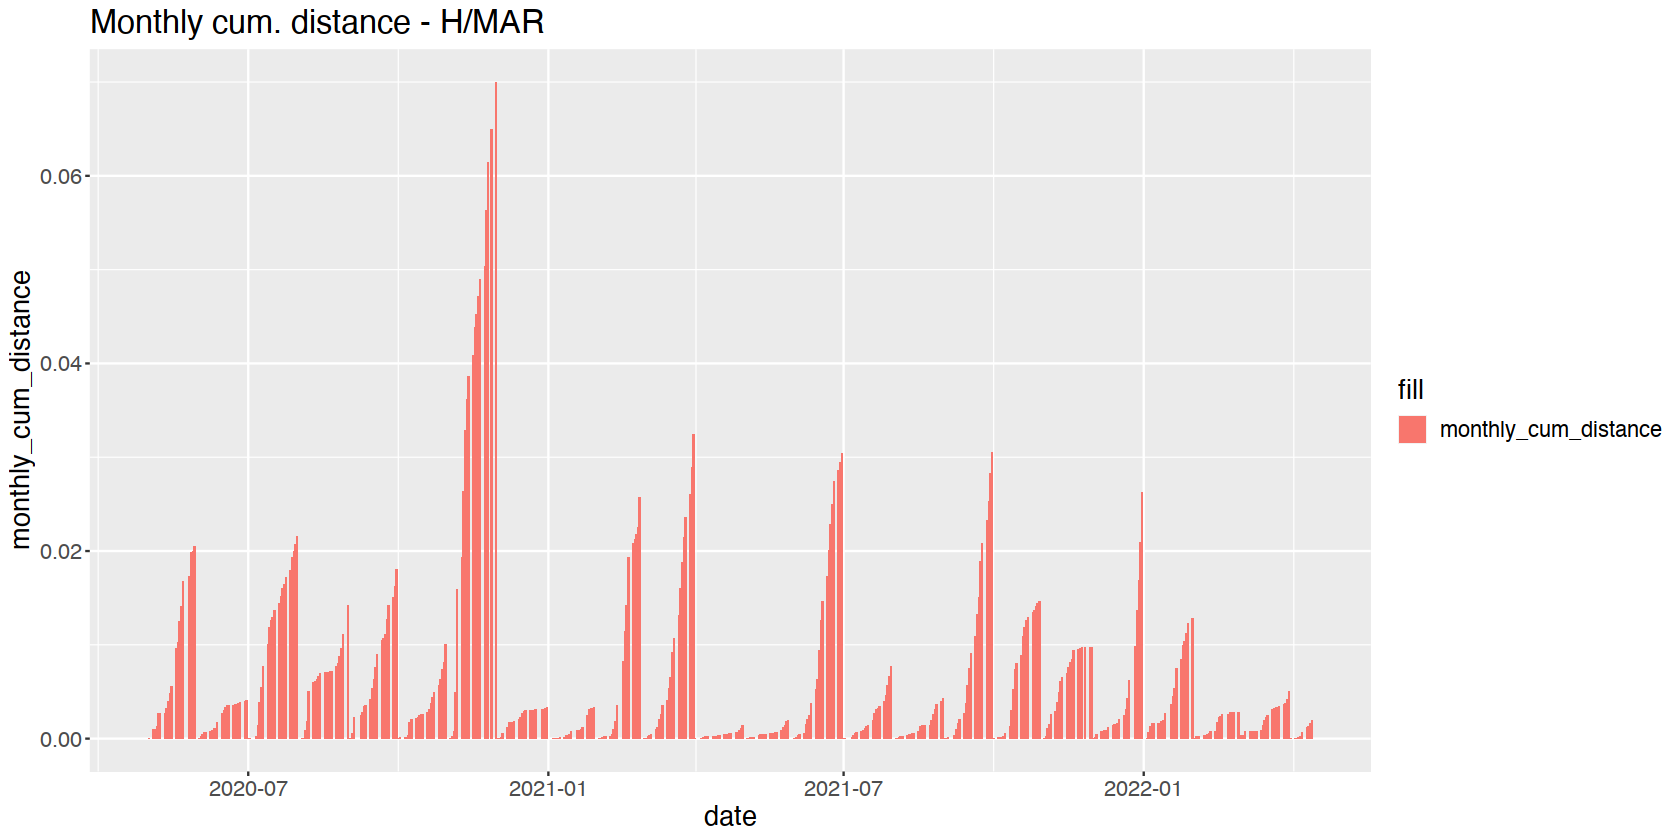

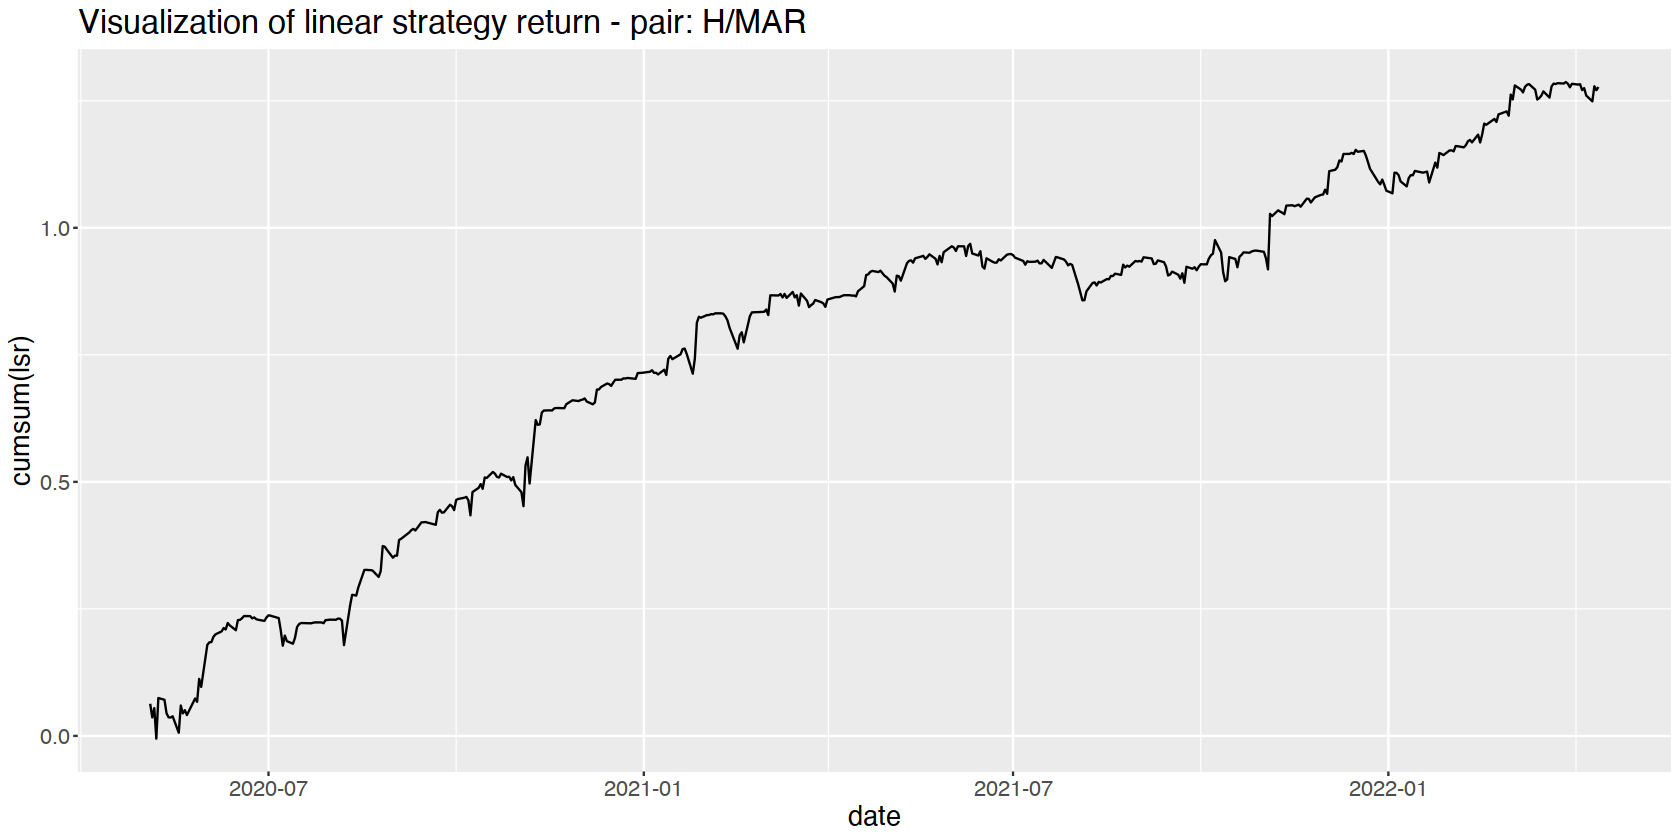

In [ ]:
pair <- pairs[3]
plot_timeseries(liquid_universe_prices,pair)
plot_spread(spreads,pair)
#plot_zscore(spreads,pair)
plot_dist(spreads,pair)
plot_lsr(lsr,pair)

# Create pairs shortlist

Last but not least we're calculating our pair weights based on their contribution of single tickers (we want to have pairs "sharing" the same ticker to have lower weight than the rest).

Also we're filtering out pairs which we (for whatever reason) don't want to have in our final pairs shortlist.

## Blacklist pairs

In [ ]:
blacklist <- c(
  "GOOG/GOOGL", # very low past total return
  "FNB/ONB",
  "FFBC/ONB",
  "ABCB/PPBI",
  "CADE/ONB",
  "BPOP/FBP" # too much concentration in regional banks
)

## Calculate pair weights, export results

In [ ]:
n <- 10
weights <- calc_pairs_weights(combo_score, blacklist, n)
weights %>% mutate(year=year(today())) %>% 
  select(year,stock1,stock2,weight) %>%
  write.table(paste0("export/pairs_shortlist_",year(today()),".csv"), sep=",", row.names=FALSE, quote=FALSE)
weights

pair,stock1,stock2,weight
<chr>,<chr>,<chr>,<dbl>
ANTM/MOH,ANTM,MOH,0.1
BXMT/LADR,BXMT,LADR,0.1
DRH/PK,DRH,PK,0.1
FFBC/FNB,FFBC,FNB,0.1
H/MAR,H,MAR,0.1
NTRS/SEIC,NTRS,SEIC,0.1
OGE/SO,OGE,SO,0.1
OHI/SBRA,OHI,SBRA,0.1
PAYC/PCTY,PAYC,PCTY,0.1


## Plot pair weights

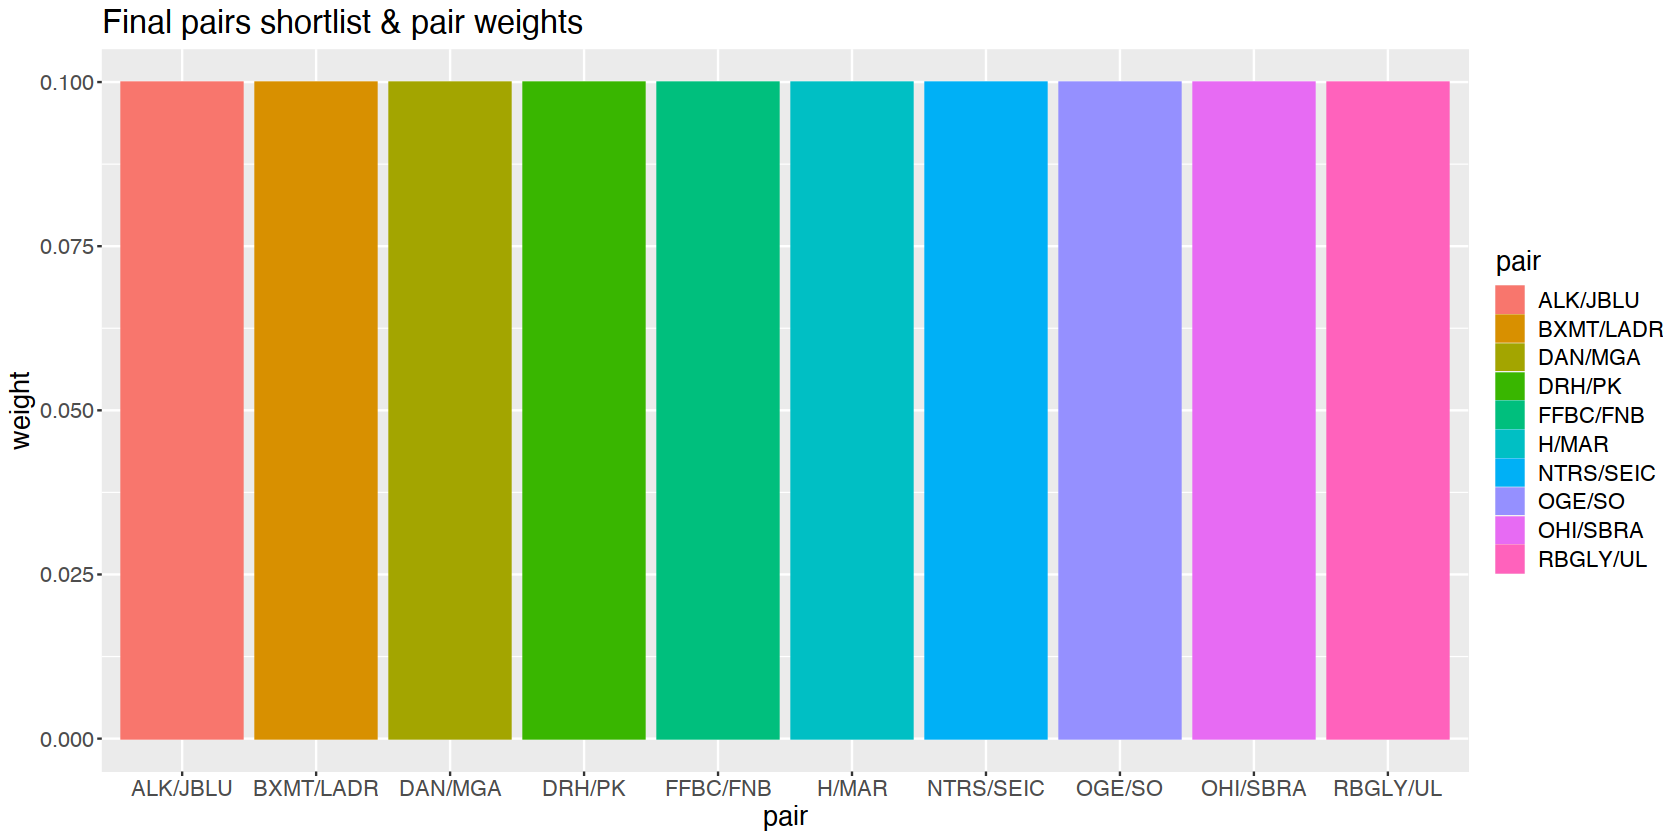

In [ ]:
weights %>% 
  mutate(pair = paste0(stock1,"/",stock2)) %>%
  ggplot(aes(x=pair,y=weight, fill=pair, color=pair)) + 
  geom_col() +
 
  ggtitle("Final pairs shortlist & pair weights")

## Plot pairs by industry

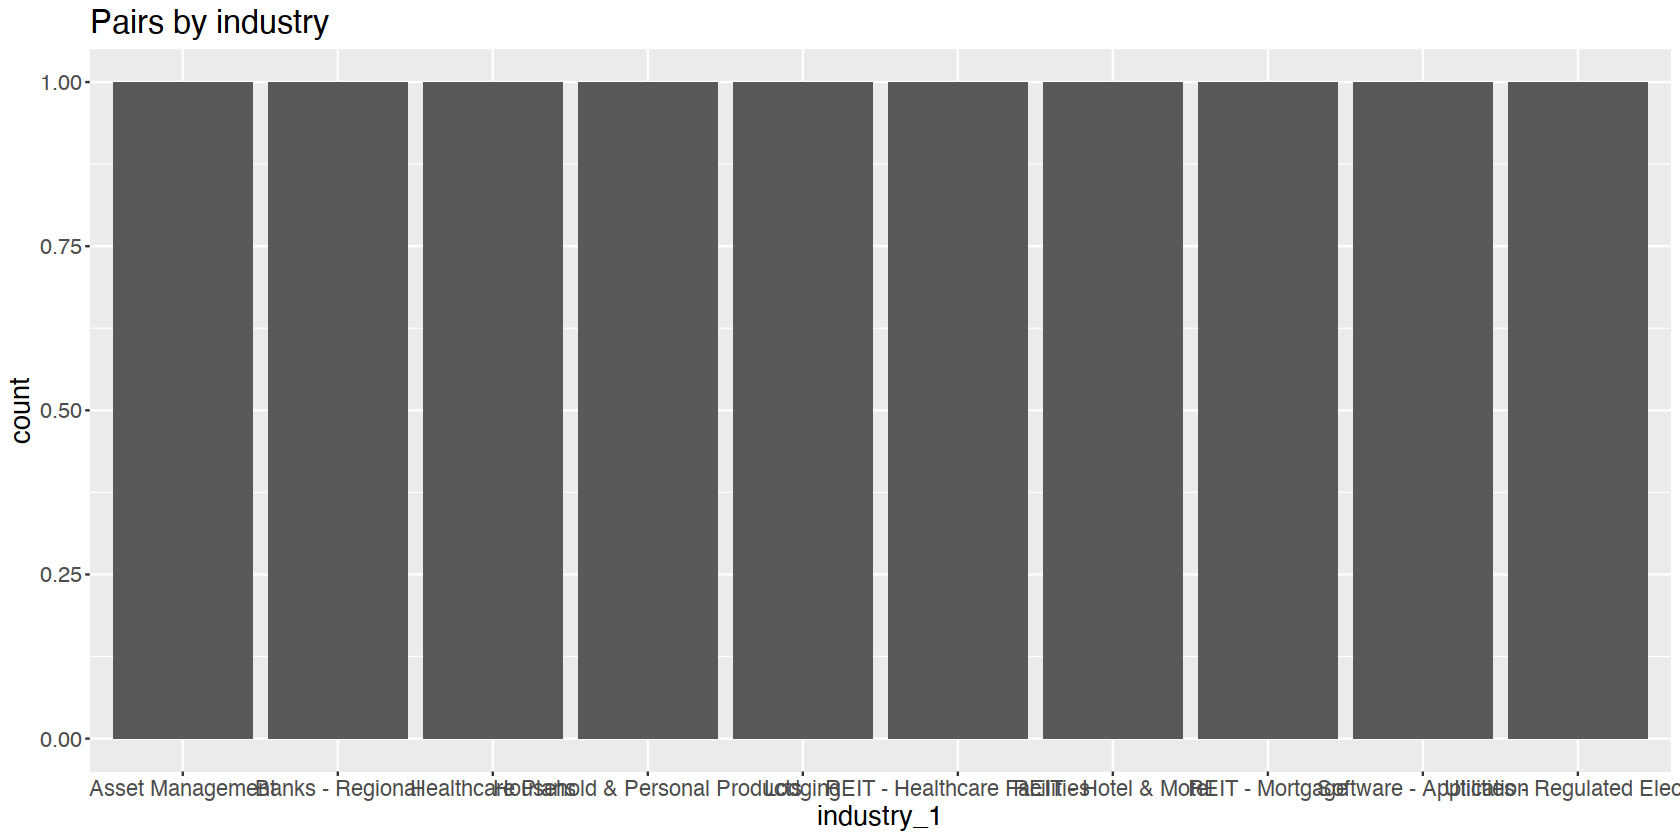

In [ ]:
combo_score %>% 
  filter(!pair%in%blacklist) %>% filter(row_number() <=n) %>%
  group_by(industry_1) %>%
  summarise(count=n()) %>%
  ggplot(aes(industry_1,count)) + geom_col() + ggtitle("Pairs by industry")